# Проект спринта "Линейные модели в машинном обучении"

## Описание проекта
Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих бурёнок!

Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

1. Первая будет прогнозировать возможный удой у коровы (целевой признак Удой);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
- Средний удой за год — не менее 6000 килограммов,
- Молоко должно быть вкусным.

## Необходимые библиотеки и настройки

In [ ]:
# !pip install seaborn -q
%pip install --upgrade numpy -q
# !pip install --upgrade pandas

# !pip install --upgrade scikit-learn -q

   
# !pip install --upgrade numpy pandas phik seaborn matplotlib -q

%pip install --upgrade phik -q
%pip install --upgrade seaborn -q
%pip install --upgrade pandas -q
%pip install --upgrade statsmodels -q
%pip install --upgrade scikit-learn -q

In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import matplotlib.gridspec as gridspec
import phik
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error
from phik.report import plot_correlation_matrix
from IPython.display import display_html
import warnings
import math

In [400]:
# plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme()

In [401]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Вспомогательные инструменты

In [402]:
def median_estimate(ferma_main, col1, ti, legend, measure, dl='ferma_main', legendbool=True, tablerepresent=False):
    graph_params = [
        ('breed', f'Медианные значения\n {ti} в зависимости от породы', 'порода'),
        ('father_breed', f'Медианные значения\n {ti} в зависимости от породы быков-отцов', 'порода быков-отцов'),
        ('milk_taste', f'Медианные значения\n {ti} в зависимости от вкуса молока', 'категория'),
        ('age', f'Медианные значения\n {ti} в зависимости от возраста', 'возрастная категория'),
        ('pasture_type', f'Медианные значения\n {ti} в зависимости от типа пастбища', 'тип пастбища'),
    ]
    if dl == 'cow_buys':
        graph_params = [
        ('breed', f'Медианные значения\n {ti} в зависимости от породы', 'порода'),
        ('father_breed', f'Медианные значения\n {ti} в зависимости от породы быков-отцов', 'порода быков-отцов'),
        ('father_name', f'Медианные значения\n {ti} в зависимости от имени быка-отца', 'имя быка-отца'),
        ('age', f'Медианные значения\n {ti} в зависимости от возраста', 'возрастная категория'),
        ('pasture_type', f'Медианные значения\n {ti} в зависимости от типа пастбища', 'тип пастбища'),
    ]
    if tablerepresent:
        for idx, (index_col, title, xl) in enumerate(graph_params[:-1]):
            display((ferma_main
         .pivot_table(index=index_col, values=col1, aggfunc='median')
         .sort_values(col1, ascending=True)
            ))
        
    else:   
        
    
        fig = plt.figure(figsize=(18, 8))
        gs = gridspec.GridSpec(2, 3)

        # Для всех графиков, кроме последнего
        for idx, (index_col, title, xl) in enumerate(graph_params[:-1]):
            row, col = divmod(idx, 2)
            ax = fig.add_subplot(gs[row, col])
            (ferma_main
         .pivot_table(index=index_col, values=col1, aggfunc='median')
         .sort_values(col1, ascending=True)
         .plot(kind='bar', ax=ax, title=title, legend=legendbool))
            ax.set_ylabel(f'Медианные значения, {measure}')
            ax.set_xlabel(xl)
            if legendbool:
                ax.legend([legend])
            ax.tick_params(axis='x', rotation=0)
            add_bar_labels(ax)

        # Для последнего графика, который занимает две колонки
        index_col, title, xl = graph_params[-1]
        ax = fig.add_subplot(gs[:, 2])
        (ferma_main
     .pivot_table(index=index_col, values=col1, aggfunc='median')
     .sort_values(col1, ascending=True)
     .plot(kind='bar', ax=ax, title=title, legend=legendbool))
        ax.set_ylabel(f'Медианные значения, {measure}')
        ax.set_xlabel(xl)
        ax.tick_params(axis='x', rotation=0)
        if legendbool:
            ax.legend([legend])
    
        add_bar_labels(ax)
        plt.tight_layout()
        plt.show()

In [403]:
def pies_or_bars(df, ax, column, common_title, categories, kind='pie'):
    ax = ax.flatten()
    
    if kind == 'bar':
        for title, (col, unique_values, offset) in categories.items():
            for i, value in enumerate(unique_values):
                (df
         .query(f'{col} == @value')
         [column]
         .value_counts()
         .plot(kind='bar',
               ylabel="Количество",
               title=f'{common_title}\n для {title}: {value}',
               ax=ax[i + offset],   
              ))
                ax[i + offset].tick_params(axis='x', rotation=0)
        

    else:
        for title, (col, unique_values, offset) in categories.items():
            for i, value in enumerate(unique_values):
                (df
         .query(f'{col} == @value')
         [column]
         .value_counts()
         .plot(kind='pie',
               autopct="%.0f%%",
               ylabel="",
               title=f'{common_title}\n для {title}: {value}',
               ax=ax[i + offset],
               colormap='Pastel2'
              ))

    plt.tight_layout()
    plt.show()

In [ ]:
def add_bar_labels(ax):
    """
    Добавляет метки к столбикам диаграммы, поддерживает старые версии matplotlib.
    """
    if hasattr(ax, 'bar_label') and len(ax.containers) > 0:  
        for container in ax.containers:
            ax.bar_label(container, fmt=f'%.2f', label_type='edge') 
    else: 
        for bar in ax.patches:
            bar_value = bar.get_width() if bar.get_width() > 0 else bar.get_height()
            text = f'{bar_value:.2f}' if bar_value < 1 else f'{int(bar_value)}'
            if bar.get_width() > 0:  
                x_pos = bar.get_x() + bar.get_width() + 0.1
                y_pos = bar.get_y() + bar.get_height() / 2
            else:  
                x_pos = bar.get_x() + bar.get_width() / 2
                y_pos = bar.get_y() + bar.get_height() + 0.1            
           
            ax.text(x_pos, y_pos, text, ha='center', va='center')
    
    plt.tight_layout() 

In [405]:
def compare_two_hist(dfs, column_name, labels, xlabel, ylabel, title, stat_labels):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    sns.histplot(data=dfs[0], 
                 x=column_name, 
                 ax=ax, 
                 alpha=0.5, 
                 color='red', 
                 label=labels[0])

    sns.histplot(data=dfs[1], 
                 x=column_name, 
                 ax=ax, 
                 color='#C7F2A4', 
                 label=labels[1])

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.vlines(dfs[0][column_name].mean(), ymin=0, ymax=600, color='#1C6758', label=stat_labels[0])
    ax.vlines(dfs[1][column_name].mean(), ymin=0, ymax=600, ls='--', color='#8B5DFF', label=stat_labels[1])
    ax.legend();plt.show()

In [406]:
def detect_outliers(df: pd.DataFrame, column_name: str, strategy: str):
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        return df.query(f'~( @mean - 3 * @std < {column_name} < @mean + 3 * @std)')
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        return df.query(f'~( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')

In [407]:
def outliers_report(df: pd.DataFrame, column_names , strategy: str):
    report = []
    for cn in column_names:
        if strategy == 'triple_sigma':
            mean = df[cn].mean()
            std = df[cn].std()
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@mean - 3 * @std > {cn}').shape[0],
            'left outliers %': df.query(f'@mean - 3 * @std > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@mean + 3 * @std < {cn}').shape[0],
            'right outliers %': df.query(f'@mean + 3 * @std < {cn}').shape[0] / df.shape[0] * 100   
        })
        elif strategy == 'iqr':
            q25 = df[cn].quantile(.25)
            q75 = df[cn].quantile(.75)
            iqr = q75 - q25
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0],
            'left outliers %': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0],
            'right outliers %': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0] / df.shape[0] * 100 
        })
    return pd.DataFrame(report).round(2)


In [408]:
def plot_graphics(df, column_name, bins=30, range_hist=None, hist_color='#519872', boxplot_color='#B9D2D2', col_alias='', xlabel='', ylabel=''):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
    ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
    ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
    ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
    ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения') 

In [409]:
def process_outliers(df: pd.DataFrame, column_name: str, strategy: str, do: str):
    df = df.copy()
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        if do == 'delete':
            return df.query(f'(@mean - 3 * @std < {column_name} < @mean + 3 * @std)')
        elif do == 'fill_na':
            df.loc[~(mean - 3 * std < df[f'{column_name}']) | ~(df[f'{column_name}'] < mean + 3 * std), f'{column_name}'] = np.nan
            return df
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        if do == 'delete':
            return df.query(f'( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')
        elif do == 'fill_na':
            df.loc[~(q25 - 1.5 * iqr < df[f'{column_name}']) | ~(df[f'{column_name}'] < q75 + 1.5 * iqr), f'{column_name}'] = np.nan
            return df

In [410]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
scaler = StandardScaler()

In [411]:
def prepare_data(X, target, categorical_columns, numeric_columns, stratify=None):
    RANDOM_STATE = 42    

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=stratify)
    
    X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_columns]), columns=encoder.get_feature_names_out())
    X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_columns]), columns=encoder.get_feature_names_out())
    
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_columns]), columns=numeric_columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_columns]), columns=numeric_columns)
    
    X_train = pd.concat([X_train_scaled, X_train_encoded], axis=1)
    X_test = pd.concat([X_test_scaled, X_test_encoded], axis=1)
    
    X_train = X_train.sort_index(axis=1)
    X_test = X_test.sort_index(axis=1)
    return X_train, X_test, y_train, y_test, encoder, scaler

In [413]:
def scores_report(predictions, y_test, title):
    rmse = root_mean_squared_error(predictions, y_test)
    mse = mean_squared_error(predictions, y_test)
    mae = mean_absolute_error(predictions, y_test)
    r2 = r2_score(y_test, predictions)

    scores =  pd.DataFrame({
    'metric': ['RMSE', 'MSE', 'MAE', '$R^2$'],
    title: [rmse, mse, mae, r2]
    }).set_index('metric')
    
    return scores

In [414]:
def analyze_residuals(residuals, predictions):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sns.histplot(residuals, ax=axes[0], color='#ECDBBA', bins=20)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].axvline(x=residuals.mean(), label='среднее', color='red', ls='--')
    axes[0].axvline(x=0, label='нулевой уровень', color='green')
    axes[0].legend()
    
    
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    axes[1].axhline(y=0, color='red', ls='--')
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

In [415]:
def corr_report(df):
    plt.figure(figsize=(5, 4))
    corr = df.corr(numeric_only=True).loc[:, ["milk_yield"]].sort_values('milk_yield', ascending=False)[1:]
    g = sns.heatmap(corr, annot=True, cmap='Greens')
    plt.yticks(rotation=0)
    plt.title('Корреляция Пирсона')
    plt.show()

    corr = df.phik_matrix(njobs=1).loc[:, ['milk_yield']].sort_values('milk_yield')[:-1]
    plot_correlation_matrix(corr.values, x_labels=corr.columns, y_labels=corr.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'Корреляция $\phi_K$', fontsize_factor=1.5,
                        figsize=(5,8))
    plt.xticks(rotation=0)
    plt.show()
    

## Загрузка данных

### Датасет `ferma_main.csv`

In [ ]:
try:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';')
except:
    ferma_main = pd.read_csv('<PATH>', sep=';')

In [417]:
ferma_main.head(5)

id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                  14,2              1743   
1   2      5529                                  12,8              2138   
2   3      5810                                    14              1854   
3   4      5895                                  12,4              2012   
4   5      5302                                  12,8              1675   

  СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0,89   Вис Бик Айдиал    Равнинное   
1                                 0,89   Вис Бик Айдиал    Равнинные   
2                                0,885  РефлешнСоверинг    Холмистое   
3                                0,885  РефлешнСоверинг    Холмистое   
4                                0,885   Вис Бик Айдиал    Равнинные   

  порода папы_быка Жирность,% Белок,% Вкус молока      Возраст  
0           Айдиал       3,58   3,076      вкусно  более_2_лет  
1          Соверин       3,54   3,079      вкусно  менее_2_лет  
2          Соверин       3,59   3,074   не вкусно  более_2_лет  
3           Айдиал        3,4   3,075   не вкусно  более_2_лет  
4          Соверин       3,73   3,073      вкусно  менее_2_лет

In [418]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

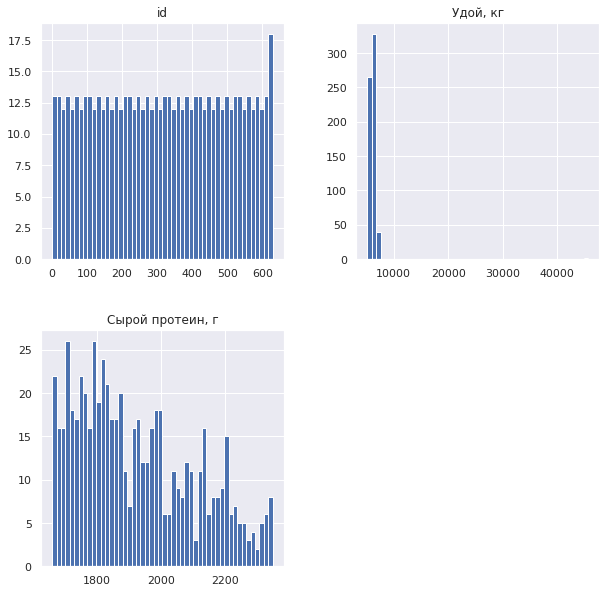

In [419]:
ferma_main.hist(figsize=(10, 10), bins=50);plt.show()

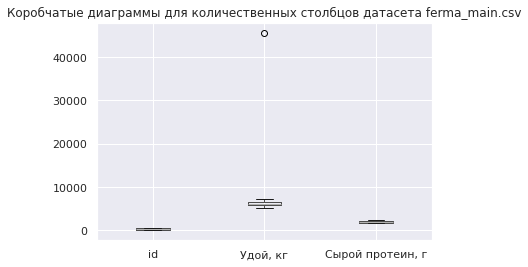

In [420]:
ferma_main.boxplot()
plt.title('Коробчатые диаграммы для количественных столбцов датасета ferma_main.csv')
plt.show()

- Столбцы [] имеют неверный тип (строчный вместо числового из-за использования запятой для отделения дробной части)
- Пропусков в данных нет
- В столбце с удоем присутствует значение, сильно отличающееся от остальных данных

### Датасет `ferma_dad.csv`

In [ ]:
try:
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
except:
    ferma_dad = pd.read_csv('<PATH>', sep=';')

In [422]:
ferma_dad.sample(5)

id  Имя Папы
287  288  Соловчик
619  620  Соловчик
247  248     Барин
169  170  Геркулес
545  546    Буйный

In [423]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


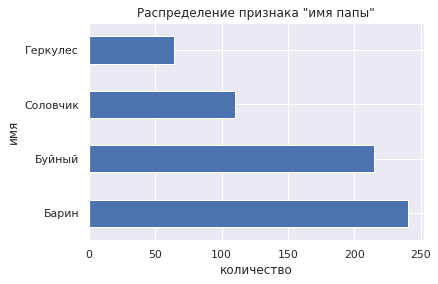

In [424]:
ax = (ferma_dad['Имя Папы']
 .value_counts()
 .plot(kind='barh',
       title='Распределение признака "имя папы"'
      ))
plt.xlabel('количество')
plt.ylabel('имя')
plt.show()


- Пропусков в данных нет
- Видимо, данный датасет будет присоединятьсяк другим и представляет собой так называемый словарь значений

### Датасет `cow_buy.csv`

In [ ]:
try:
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';')
except:
    cow_buy = pd.read_csv('<PATH>', sep=';')

In [426]:
cow_buy.sample(5)

Порода Тип пастбища порода папы_быка  Имя_папы  \
8   РефлешнСоверинг    равнинное          Соверин     Барин   
10   Вис Бик Айдиал    холмистое          Соверин  Соловчик   
2   РефлешнСоверинг    равнинное          Соверин     Барин   
1    Вис Бик Айдиал    равнинное          Соверин    Буйный   
5   РефлешнСоверинг    равнинное          Соверин  Геркулес   

   Текущая_жирность,% Текущий_уровень_белок,%      Возраст  
8                3,59                   3,074  более_2_лет  
10               3,73                   3,055  более_2_лет  
2                3,59                   3,074  более_2_лет  
1                3,54                   3,081  менее_2_лет  
5                3,63                   3,053  менее_2_лет

In [427]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


- Столбцы [] имеют неверный тип (строчный вместо числового из-за использования запятой для отделения дробной части)
- Пропусков в данных нет
- Тоже похож на словарь для обогащения других датасетов

### Переименование столбцов

In [428]:
ferma_main.columns

Index(['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
       'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Порода',
       'Тип пастбища', 'порода папы_быка', 'Жирность,%', 'Белок,%',
       'Вкус молока', 'Возраст'],
      dtype='object')

In [429]:
ferma_main.rename(columns={
    'Удой, кг': 'milk_yield',
    'ЭКЕ (Энергетическая кормовая единица)': 'efu',
    'Сырой протеин, г': 'raw_protein',
    'СПО (Сахаро-протеиновое соотношение)': 'spo',
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'father_breed',
    'Жирность,%': 'fat_content',
    'Белок,%': 'protein',
    'Вкус молока': 'milk_taste',
    'Возраст': 'age'
},
                 inplace=True)

In [430]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            634 non-null    int64 
 1   milk_yield    634 non-null    int64 
 2   efu           634 non-null    object
 3   raw_protein   634 non-null    int64 
 4   spo           634 non-null    object
 5   breed         634 non-null    object
 6   pasture_type  634 non-null    object
 7   father_breed  634 non-null    object
 8   fat_content   634 non-null    object
 9   protein       634 non-null    object
 10  milk_taste    634 non-null    object
 11  age           634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


In [431]:
ferma_dad.columns

Index(['id', 'Имя Папы'], dtype='object')

In [432]:
ferma_dad.rename(columns={
    'Имя Папы': 'father_name',
},
                 inplace=True)

In [433]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           629 non-null    int64 
 1   father_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [434]:
cow_buy.columns

Index(['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя_папы',
       'Текущая_жирность,%', 'Текущий_уровень_белок,%', 'Возраст'],
      dtype='object')

In [435]:
cow_buy.rename(columns={
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'father_breed',
    'Имя_папы': 'father_name',
    'Текущая_жирность,%': 'current_fat_content',
    'Текущий_уровень_белок,%': 'current_protein_level',
    'Возраст': 'age'
},
                 inplace=True)

In [436]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   breed                  20 non-null     object
 1   pasture_type           20 non-null     object
 2   father_breed           20 non-null     object
 3   father_name            20 non-null     object
 4   current_fat_content    20 non-null     object
 5   current_protein_level  20 non-null     object
 6   age                    20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


- Были изменены названия столбцов на английские аналоги
- Были исследованы заданные датасеты
- Пропусков в данных не обнаружено

## Предобработка данных

### Датасет `ferma_main.csv`

#### Явные дубликаты

In [437]:
ferma_main[ferma_main.duplicated()]

id  milk_yield   efu  raw_protein   spo            breed pasture_type  \
629  627        5970  14,4         1837  0,88  РефлешнСоверинг    Холмистое   
630  627        5970  14,4         1837  0,88  РефлешнСоверинг    Холмистое   
631  627        5970  14,4         1837  0,88  РефлешнСоверинг    Холмистое   
632  627        5970  14,4         1837  0,88  РефлешнСоверинг    Холмистое   
633  627        5970  14,4         1837  0,88  РефлешнСоверинг    Холмистое   

    father_breed fat_content protein milk_taste          age  
629      Соверин        3,64   3,075  не вкусно  более_2_лет  
630      Соверин        3,64   3,075  не вкусно  более_2_лет  
631      Соверин        3,64   3,075  не вкусно  более_2_лет  
632      Соверин        3,64   3,075  не вкусно  более_2_лет  
633      Соверин        3,64   3,075  не вкусно  более_2_лет

Есть пять полных дубликатов, удалим их по стратегии keep-first

In [438]:
ferma_main.drop_duplicates(keep='first', inplace=True)

In [439]:
ferma_main.query('id == 627')

id  milk_yield   efu  raw_protein   spo            breed pasture_type  \
626  627        5970  14,4         1837  0,88  РефлешнСоверинг    Холмистое   

    father_breed fat_content protein milk_taste          age  
626      Соверин        3,64   3,075  не вкусно  более_2_лет

#### Работа со столбцами `father_breed`, `pasture_type`, `age`

Посмотрим на категориальные признаки и проверим их на неявные дубликаты

In [440]:
ferma_main.father_breed.value_counts()

father_breed
Соверин    311
Айдиал     240
Айдиалл     78
Name: count, dtype: int64

Видим очень похожие породы быков-отцов. Айдиалл и Айдиал.

In [441]:
ferma_main.query('father_breed == "Айдиалл"').shape[0], ferma_main.query('father_breed == "Айдиал"').shape[0]

(78, 240)

Здесь явно допущена опечатка, Айдиалл нужно поменять на Айдиал

In [442]:
ferma_main.replace({
    'Айдиалл': 'Айдиал'
},
inplace=True)

In [443]:
ferma_main.pasture_type.value_counts()

pasture_type
Холмистое    351
Равнинное    253
Равнинные     25
Name: count, dtype: int64

Здесь тоже допущена опечатка, Равнинное и Равнинные - дублирующие названия типа пастбищ

In [444]:
ferma_main.query('pasture_type == "Равнинное"').shape[0], ferma_main.query('pasture_type == "Равнинные"').shape[0]

(253, 25)

In [445]:
ferma_main.replace({
    'Равнинные': 'Равнинное'
},
inplace=True)

In [446]:
ferma_main['pasture_type'] = ferma_main['pasture_type'].str.lower()

In [447]:
ferma_main['pasture_type'].head()

0    равнинное
1    равнинное
2    холмистое
3    холмистое
4    равнинное
Name: pasture_type, dtype: object

In [448]:
ferma_main['age'] = ferma_main['age'].replace({'_': ' '}, regex=True)

- Выявлены дублирующие категории
    
    1. `Айдиал` и `Айдиалл`
    2. `Равнинное` и `Равнинные`
    3. Выполнена замена
       
        - `Айдиалл` $\rightarrow$ `Айдиал`
        - `Равнинные` $\rightarrow$ `Равнинное`
- Убрано нижнее подчеркивание из столбца `age`

#### Работа со столбцом `efu` (ЭКЕ)

Посмотрим на значения признака ЭКЕ

In [449]:
ferma_main.efu

0      14,2
1      12,8
2        14
3      12,4
4      12,8
       ... 
624    15,4
625    12,9
626    14,4
627    13,8
628    16,2
Name: efu, Length: 629, dtype: object

In [450]:
ferma_main.efu.dtype

dtype('O')

изменим тип столбца на числовой

In [451]:
ferma_main['efu'] = ferma_main['efu'].replace({',': '.'}, regex=True).astype('float')

In [452]:
ferma_main.efu.dtype

dtype('float64')

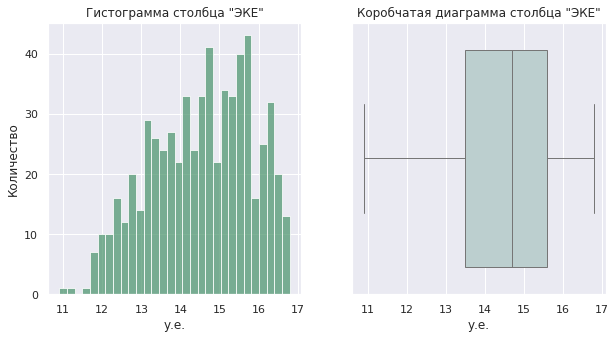

In [453]:
plot_graphics(ferma_main, 'efu', col_alias='"ЭКЕ"', xlabel='у.е.')

Все ок, теперь признак ЭКЕ числовой. Можно посмотреть на гистограмму и оценить его распределение

#### Работа со столбцом `spo` (СПО)

In [454]:
ferma_main.spo

0       0,89
1       0,89
2      0,885
3      0,885
4      0,885
       ...  
624     0,94
625     0,88
626     0,88
627     0,89
628     0,94
Name: spo, Length: 629, dtype: object

In [455]:
ferma_main.spo.dtype

dtype('O')

изменим тип столбца на числовой

In [456]:
ferma_main['spo'] = ferma_main['spo'].replace({',': '.'}, regex=True).astype('float')

In [457]:
ferma_main.spo.dtype

dtype('float64')

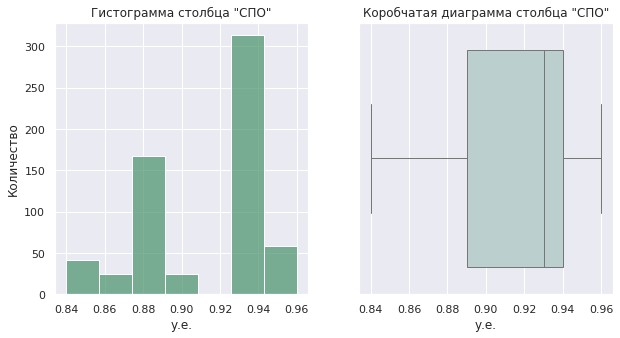

In [458]:
plot_graphics(ferma_main, 'spo', col_alias='"СПО"', xlabel='у.е.', bins=7)

Аналогично заменили запятую на точку. Теперь признак числовой

#### Работа со столбцом `fat_content` (Жирность)

In [459]:
ferma_main.fat_content

0      3,58
1      3,54
2      3,59
3       3,4
4      3,73
       ... 
624    3,74
625    3,64
626    3,64
627    3,64
628    3,71
Name: fat_content, Length: 629, dtype: object

In [460]:
ferma_main.fat_content.dtype

dtype('O')

изменим тип столбца на числовой

In [461]:
ferma_main['fat_content'] = ferma_main['fat_content'].replace({',': '.'}, regex=True).astype('float')

In [462]:
ferma_main.fat_content.dtype

dtype('float64')

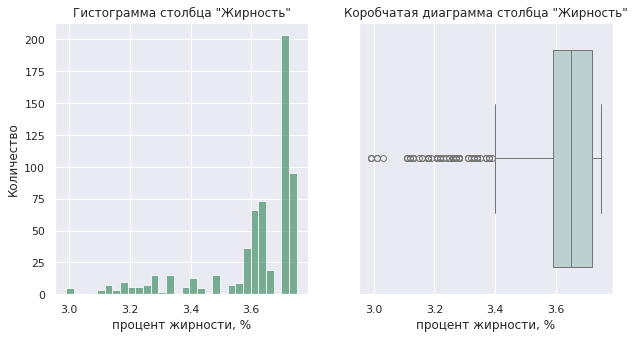

In [463]:
plot_graphics(ferma_main, 'fat_content', col_alias='"Жирность"', xlabel='процент жирности, %')

Заменили запятую на точку. Теперь параметры жирности числовые, видим некоторое количество выбросов

#### Работа со столбцом `protein` (белок)

In [464]:
ferma_main.protein

0      3,076
1      3,079
2      3,074
3      3,075
4      3,073
       ...  
624    3,075
625    3,073
626    3,075
627    3,077
628    3,076
Name: protein, Length: 629, dtype: object

In [465]:
ferma_main.protein.dtype

dtype('O')

изменим тип столбца на числовой

In [466]:
ferma_main['protein'] = ferma_main['protein'].replace({',': '.'}, regex=True).astype('float')

In [467]:
ferma_main.protein.dtype

dtype('float64')

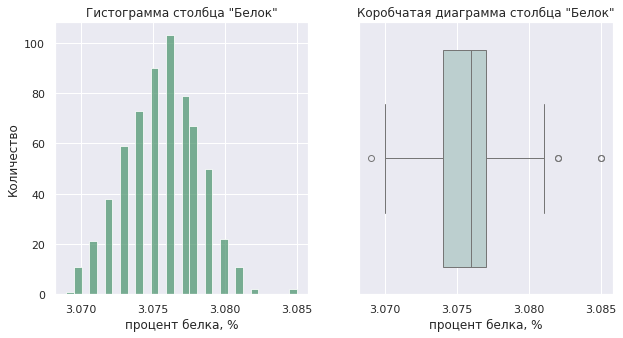

In [468]:
plot_graphics(ferma_main, 'protein', col_alias='"Белок"', xlabel='процент белка, %')

Конвертировали тип данных в числовой. Оценили гистограммой распределение признака, видим некоторую дискретность значений

Вывод:

- Нашли и удалили полные дубликаты в данных
- Преобразовали типы данных заменой запятой на точку (строки в числа)
- Нашли неявные дубликаты в столбцах с породой и типом пастбищ (опечатки)
- Убрали нижнее подчеркивание из столбца `age`

### Датасет `cow_buy.csv`

In [469]:
cow_buy

breed pasture_type father_breed father_name current_fat_content  \
0    Вис Бик Айдиал    холмистое       Айдиал    Геркулес                3,58   
1    Вис Бик Айдиал    равнинное      Соверин      Буйный                3,54   
2   РефлешнСоверинг    равнинное      Соверин       Барин                3,59   
3   РефлешнСоверинг    холмистое       Айдиал      Буйный                 3,4   
4   РефлешнСоверинг    равнинное       Айдиал      Буйный                3,64   
5   РефлешнСоверинг    равнинное      Соверин    Геркулес                3,63   
6    Вис Бик Айдиал    холмистое       Айдиал    Геркулес                3,58   
7    Вис Бик Айдиал    равнинное      Соверин      Буйный                3,57   
8   РефлешнСоверинг    равнинное      Соверин       Барин                3,59   
9   РефлешнСоверинг    холмистое       Айдиал      Буйный                 3,4   
10   Вис Бик Айдиал    холмистое      Соверин    Соловчик                3,73   
11  РефлешнСоверинг    равнинное      Соверин    Геркулес                3,73   
12   Вис Бик Айдиал    холмистое       Айдиал    Геркулес                3,68   
13   Вис Бик Айдиал    холмистое      Соверин       Барин                3,42   
14  РефлешнСоверинг    равнинное      Соверин       Барин                3,59   
15  РефлешнСоверинг    холмистое       Айдиал      Буйный                 3,4   
16   Вис Бик Айдиал    холмистое      Соверин    Соловчик                3,73   
17  РефлешнСоверинг    равнинное      Соверин    Геркулес                3,77   
18   Вис Бик Айдиал    равнинное      Соверин      Буйный                3,34   
19  РефлешнСоверинг    равнинное       Айдиал      Буйный                3,64   

   current_protein_level          age  
0                  3,076  более_2_лет  
1                  3,081  менее_2_лет  
2                  3,074  более_2_лет  
3                  3,061  более_2_лет  
4                  3,074  более_2_лет  
5                  3,053  менее_2_лет  
6                  3,076  более_2_лет  
7                  3,079  более_2_лет  
8                  3,074  более_2_лет  
9                  3,079  менее_2_лет  
10                 3,055  более_2_лет  
11                 3,073  более_2_лет  
12                 3,046  более_2_лет  
13                 3,075  менее_2_лет  
14                 3,074  более_2_лет  
15                 3,065  более_2_лет  
16                 3,079  более_2_лет  
17                 3,053  менее_2_лет  
18                 3,069  более_2_лет  
19                 3,074  более_2_лет

#### Явные дубликаты

In [471]:
cow_buy[cow_buy.duplicated()]

breed pasture_type father_breed father_name current_fat_content  \
6    Вис Бик Айдиал    холмистое       Айдиал    Геркулес                3,58   
8   РефлешнСоверинг    равнинное      Соверин       Барин                3,59   
14  РефлешнСоверинг    равнинное      Соверин       Барин                3,59   
19  РефлешнСоверинг    равнинное       Айдиал      Буйный                3,64   

   current_protein_level          age  
6                  3,076  более_2_лет  
8                  3,074  более_2_лет  
14                 3,074  более_2_лет  
19                 3,074  более_2_лет

Несмотря на то, что в данных есть явные дубликаты, удалять их не будем, так как здесь не присутствует идентификатор коровы, кроме того заказчик ожидает прогноз по всем коровам ЭкоФермы

In [472]:
cow_buy

breed pasture_type father_breed father_name current_fat_content  \
0    Вис Бик Айдиал    холмистое       Айдиал    Геркулес                3,58   
1    Вис Бик Айдиал    равнинное      Соверин      Буйный                3,54   
2   РефлешнСоверинг    равнинное      Соверин       Барин                3,59   
3   РефлешнСоверинг    холмистое       Айдиал      Буйный                 3,4   
4   РефлешнСоверинг    равнинное       Айдиал      Буйный                3,64   
5   РефлешнСоверинг    равнинное      Соверин    Геркулес                3,63   
6    Вис Бик Айдиал    холмистое       Айдиал    Геркулес                3,58   
7    Вис Бик Айдиал    равнинное      Соверин      Буйный                3,57   
8   РефлешнСоверинг    равнинное      Соверин       Барин                3,59   
9   РефлешнСоверинг    холмистое       Айдиал      Буйный                 3,4   
10   Вис Бик Айдиал    холмистое      Соверин    Соловчик                3,73   
11  РефлешнСоверинг    равнинное      Соверин    Геркулес                3,73   
12   Вис Бик Айдиал    холмистое       Айдиал    Геркулес                3,68   
13   Вис Бик Айдиал    холмистое      Соверин       Барин                3,42   
14  РефлешнСоверинг    равнинное      Соверин       Барин                3,59   
15  РефлешнСоверинг    холмистое       Айдиал      Буйный                 3,4   
16   Вис Бик Айдиал    холмистое      Соверин    Соловчик                3,73   
17  РефлешнСоверинг    равнинное      Соверин    Геркулес                3,77   
18   Вис Бик Айдиал    равнинное      Соверин      Буйный                3,34   
19  РефлешнСоверинг    равнинное       Айдиал      Буйный                3,64   

   current_protein_level          age  
0                  3,076  более_2_лет  
1                  3,081  менее_2_лет  
2                  3,074  более_2_лет  
3                  3,061  более_2_лет  
4                  3,074  более_2_лет  
5                  3,053  менее_2_лет  
6                  3,076  более_2_лет  
7                  3,079  более_2_лет  
8                  3,074  более_2_лет  
9                  3,079  менее_2_лет  
10                 3,055  более_2_лет  
11                 3,073  более_2_лет  
12                 3,046  более_2_лет  
13                 3,075  менее_2_лет  
14                 3,074  более_2_лет  
15                 3,065  более_2_лет  
16                 3,079  более_2_лет  
17                 3,053  менее_2_лет  
18                 3,069  более_2_лет  
19                 3,074  более_2_лет

#### Работа со столбцами `father_breed`, `pasture_type`, `father_name`, `age`, `breed`

Проверим на неявные дубликаты

In [480]:
cow_buy.father_breed.value_counts()

father_breed
Соверин    12
Айдиал      8
Name: count, dtype: int64

In [481]:
cow_buy.pasture_type.value_counts()

pasture_type
равнинное    11
холмистое     9
Name: count, dtype: int64

In [482]:
cow_buy.father_name.value_counts()

father_name
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: count, dtype: int64

In [483]:
cow_buy.age.value_counts()

age
более 2 лет    15
менее 2 лет     5
Name: count, dtype: int64

In [484]:
cow_buy.breed.value_counts()

breed
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: count, dtype: int64

В столбце `age` уберем нижнее подчеркивание

In [485]:
cow_buy['age'] = cow_buy['age'].replace({'_': ' '}, regex=True)

In [486]:
cow_buy.age.value_counts()

age
более 2 лет    15
менее 2 лет     5
Name: count, dtype: int64

#### Работа со столбцом `current_fat_content`

In [487]:
cow_buy.current_fat_content

0     3,58
1     3,54
2     3,59
3      3,4
4     3,64
5     3,63
6     3,58
7     3,57
8     3,59
9      3,4
10    3,73
11    3,73
12    3,68
13    3,42
14    3,59
15     3,4
16    3,73
17    3,77
18    3,34
19    3,64
Name: current_fat_content, dtype: object

In [488]:
cow_buy.current_fat_content.dtype

dtype('O')

Меняем тип данных на числовой методом `replace`

In [489]:
cow_buy['current_fat_content'] = cow_buy['current_fat_content'].replace({',':'.'}, regex=True).astype(float)

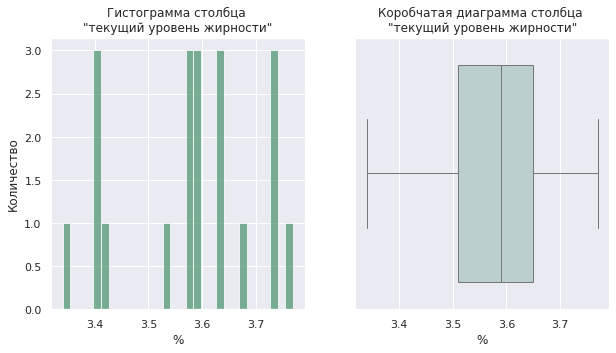

In [490]:
plot_graphics(cow_buy, 'current_fat_content', col_alias='\n"текущий уровень жирности"', xlabel='%')

#### Работа со столбцом `current_protein_level`

In [491]:
cow_buy['current_protein_level']

0     3,076
1     3,081
2     3,074
3     3,061
4     3,074
5     3,053
6     3,076
7     3,079
8     3,074
9     3,079
10    3,055
11    3,073
12    3,046
13    3,075
14    3,074
15    3,065
16    3,079
17    3,053
18    3,069
19    3,074
Name: current_protein_level, dtype: object

In [492]:
cow_buy['current_protein_level'].dtype

dtype('O')

Изменим тип данных на числовой

In [493]:
cow_buy['current_protein_level'] = cow_buy['current_protein_level'].replace({',':'.'}, regex=True).astype('float')

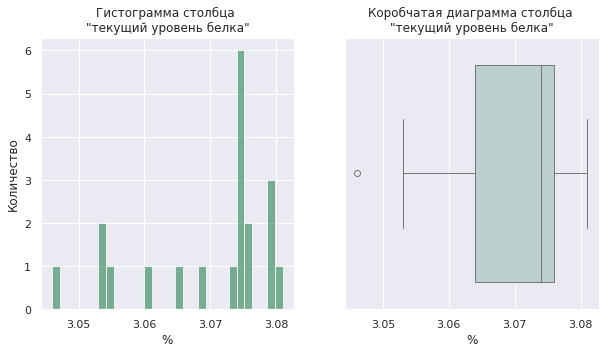

In [494]:
plot_graphics(cow_buy, 'current_protein_level', col_alias='\n"текущий уровень белка"', xlabel='%')

Вывод:

- Нашли и удалили полные дубликаты
- Преобразовали типы данных заменой запятой на точку (строки в числа)
- Неявных дубликатов не выявлено
- Убрали нижнее подчеркивание из столбца `age`

### Датасет `ferma_dad.csv`

#### Явные дубликаты

In [495]:
ferma_dad[ferma_dad.duplicated()]

Empty DataFrame
Columns: [id, father_name]
Index: []

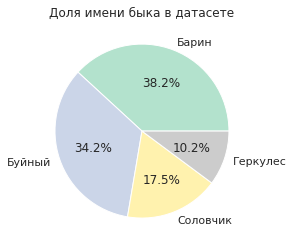

In [496]:
ferma_dad.father_name.value_counts().plot(kind='pie',
               autopct="%.1f%%",
               ylabel="",
               title='Доля имени быка в датасете', colormap='Pastel2');plt.show()

Вывод по разделу:
- Выявили полные дубликаты, а затем удалили их
- Изменили типы данных для столбцов, которые предполагались в ТЗ как числовые. Проблема крылась в использовании запятой как разделителя целой и дробных частей
- Убрали нижнее подчеркивание из столбца с возрастной категорией
- Выявили невяные дубликаты в данных по пастбищам и породе. Привели к нужным категориям. Скорее всего это была опечатка

## Исследовательский анализ данных

### Датасет `ferma_main.csv`

#### Работа со столбцом `milk_yield` (удой)

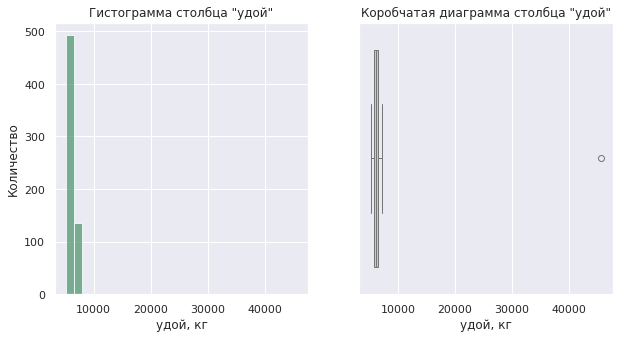

In [497]:
plot_graphics(ferma_main, 'milk_yield', col_alias='"удой"', xlabel='удой, кг')

Видим очень сильный выброс справа, найдем его

In [498]:
detect_outliers(ferma_main, 'milk_yield', strategy='iqr')

id  milk_yield   efu  raw_protein   spo           breed pasture_type  \
16  17       45616  11.5         1675  0.93  Вис Бик Айдиал    холмистое   

   father_breed  fat_content  protein milk_taste          age  
16       Айдиал         3.22    3.076     вкусно  более 2 лет

Удалим его

In [499]:
ferma_main.drop(16, inplace=True)

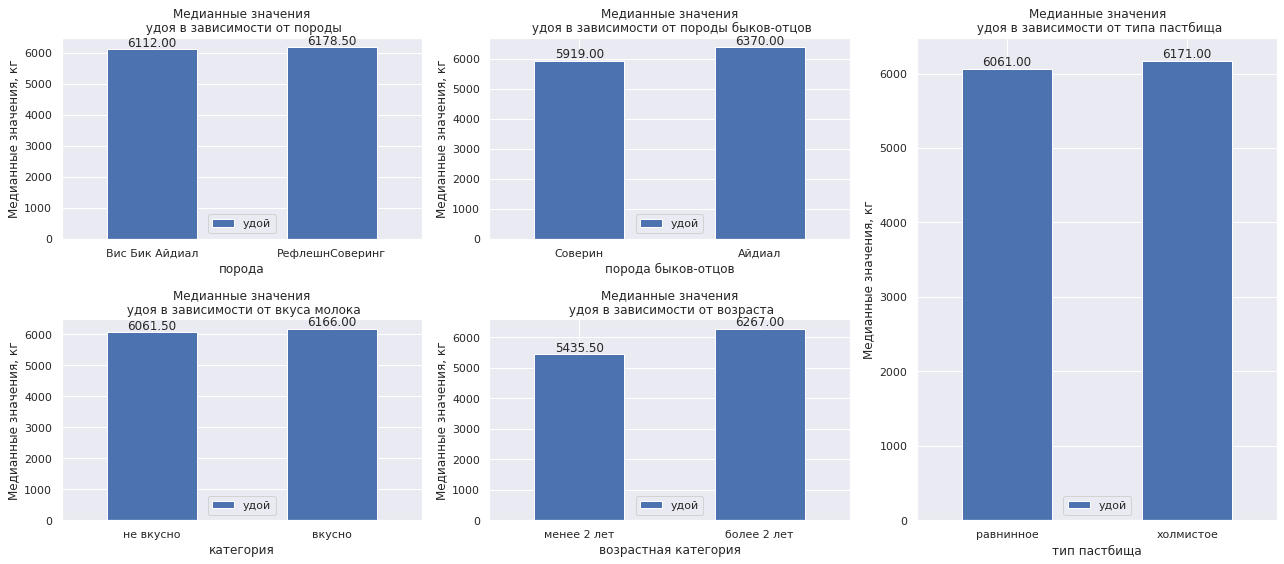

In [500]:
median_estimate(ferma_main, 'milk_yield', 'удоя', 'удой', 'кг')

- Видим выброс - корова с `id=17` имеет огромный годовой удой. Удалили эту строку
- Анализ типичных (в данном случае медианных значений) показывает следующее:

    1. Медианный удой коров породы `РефлешнСоверин` выше чем у коров породы `Вис Бик Айдиал`
    2. Медианный удой коров, отцы-быки которых имеют породу `Айдиал` выше, чем тем, чьи отцы-быки имеют породу `Соверин`
    3. Медианные значения удоя вкусного молока все таки выше чем невкусного
    4. Коровы постарше по медиане дают больший удой
    5. Удой на холмистых пастбищах побольше чем на равнинных  

#### Работа со столбцом `efu` (ЭКЕ)

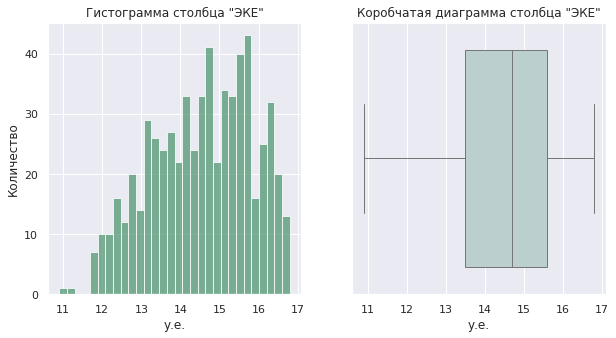

In [501]:
plot_graphics(ferma_main, 'efu', col_alias='"ЭКЕ"', xlabel='у.е.')

Видим странные значения слева на гистограмме

In [502]:
ferma_main['efu_category'] = ferma_main['efu'].apply(lambda x: 'low' if x < 12 else 'high')

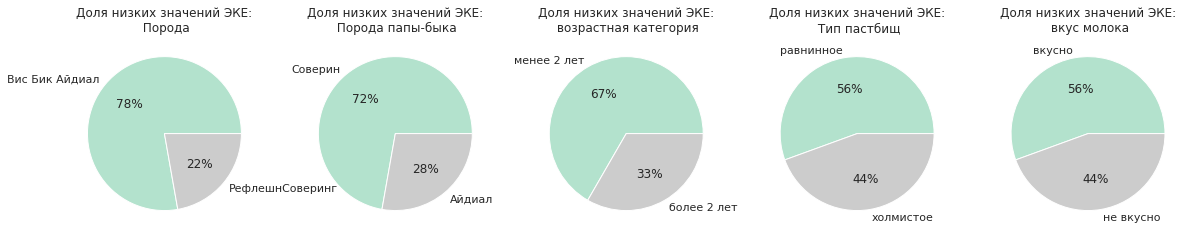

In [503]:
categories = [('breed', 'Порода'), 
              ('father_breed', 'Порода папы-быка'), 
              ('age', 'возрастная категория'), 
              ('pasture_type', 'Тип пастбищ'), 
              ('milk_taste', 'вкус молока')]
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax = ax.flatten()
for i in range(len(ax)):

    (ferma_main
 .query('efu_category == "low"')[categories[i][0]]
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       ax=ax[i],
       title=f'Доля низких значений ЭКЕ:\n {categories[i][1]}',
               colormap='Pastel2'
      ))

Итак, низкие значения ЭКЕ присущи:
- Удою коров породы `Вис Бик Айдиал`
- Удою коров с породой папы-быка `Соверин`
- Удою коров, чей возраст `менее 2 лет`

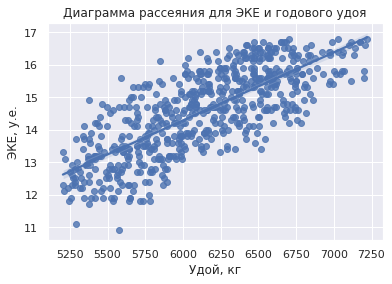

In [504]:
g = sns.regplot(
    data=ferma_main
        .query('milk_yield < 40000'),
    x='milk_yield', 
    y='efu'
)
    # hue='категория ЭКЕ')
g.set_title('Диаграмма рассеяния для ЭКЕ и годового удоя')
g.set_xlabel('Удой, кг')
g.set_ylabel('ЭКЕ, у.е.')

plt.show()

Видим довольно большую взаимосвязь по диаграмме рассеяния

In [505]:
(ferma_main
 .query('milk_yield < 40000')
 .milk_yield
 .corr(ferma_main
       .query('milk_yield < 40000')
       .efu)
 .round(2))

0.77

Корелляция Пирсона довольно высокая между признаками `Удой` и `ЭКЕ`

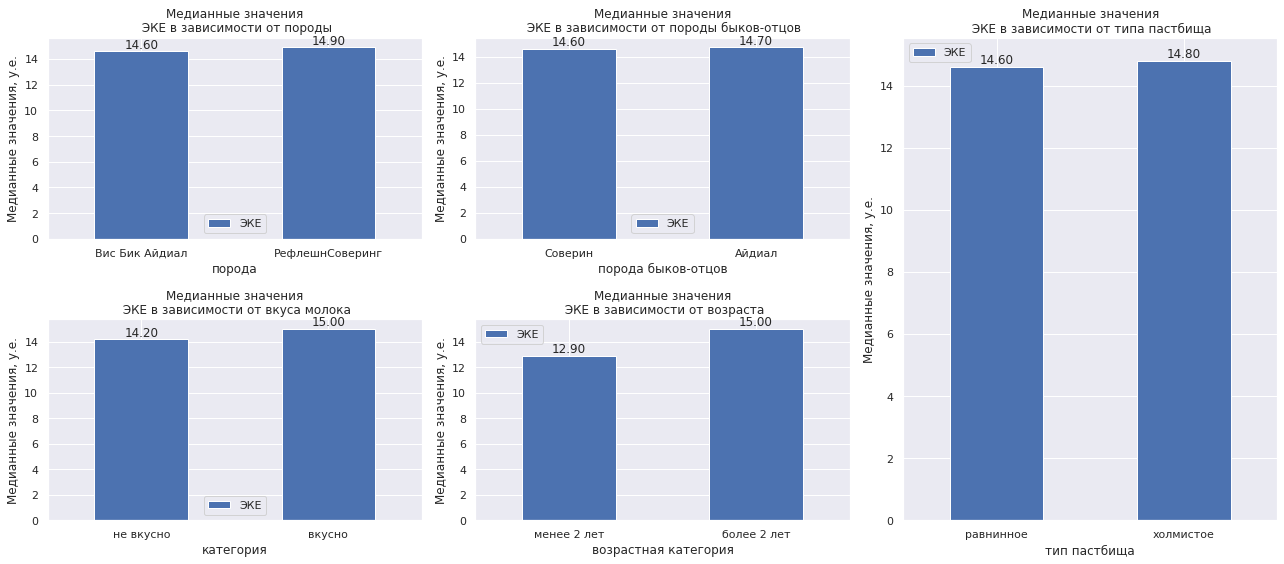

In [506]:
median_estimate(ferma_main, 'efu', 'ЭКЕ', 'ЭКЕ', 'у.е.', tablerepresent=False)

Анализ типичных (в данном случае медианных значений) показывает следующее:

- Типичные значения ЭКЕ в зависимости от породы почти одинаковые, однако чуть выше для молока коров проды `РефлешнСоверин`
- Типичные значения ЭКЕ почти одинаковые в зависимости от породы папы-быка, однако чуть выше для молока коров, имеющих папу-быка породы  `Айдиал`
- Типичное значение ЭКЕ вкусного молока на 0.8 у.е. выше чем невкусного (15 против 14.2)
- Коровы постарше дают молоко с более высоким значением ЭКЕ
- Типичные значения ЭКЕ для равнинных и холмистых пастбищ почти одинаковые, но молоко коров холмистых пастбищ имеет более высокое значение ЭКЕ

#### Работа со столбцом `raw_protein` (сырой протеин)

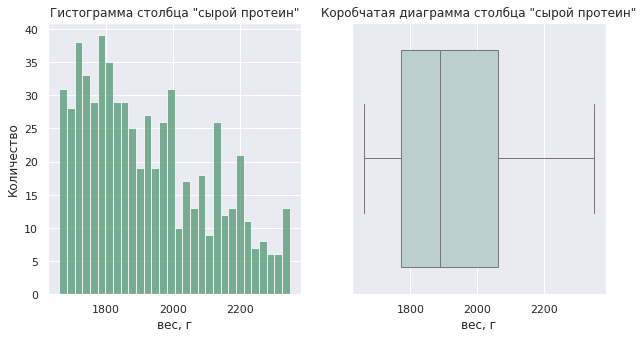

In [507]:
plot_graphics(ferma_main, 'raw_protein', col_alias='"сырой протеин"', xlabel='вес, г')

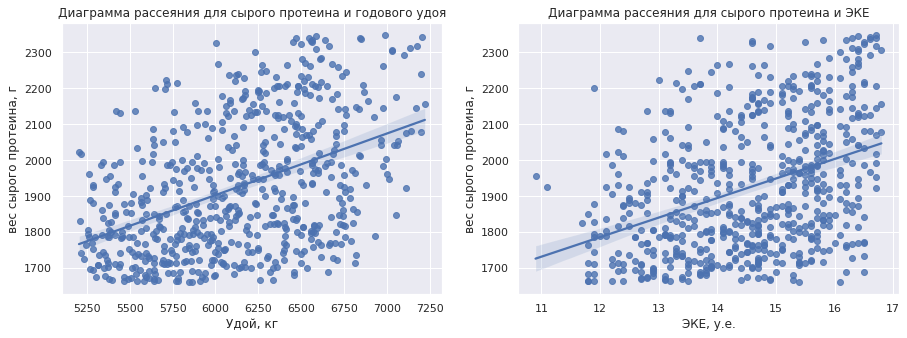

In [508]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

g = sns.regplot(
    data=ferma_main,
    x='milk_yield', 
    y='raw_protein',
    ax=ax[0]
)
g.set_title('Диаграмма рассеяния для сырого протеина и годового удоя')
g.set_xlabel('Удой, кг')
g.set_ylabel('вес сырого протеина, г')



g = sns.regplot(
    data=ferma_main,
    x='efu', 
    y='raw_protein',
    ax=ax[1]
)
g.set_title('Диаграмма рассеяния для сырого протеина и ЭКЕ')
g.set_xlabel('ЭКЕ, у.е.')
g.set_ylabel('вес сырого протеина, г')

plt.show()

- Здесь особой взаимосвязи не наблюдается. 
- Однако есть зависимость дисперсии сырого протеина: чем больше значение ЭКЕ, тем больше разброс в значениях сырого протеина

In [509]:
(ferma_main
 .milk_yield
 .corr(ferma_main
       .raw_protein)
 .round(2),
 ferma_main
 .efu
 .corr(ferma_main.raw_protein)
 .round(2)
)

(0.45, 0.39)

Корелляция Пирсона невысокая, что подтверждается диаграммой рассеяния

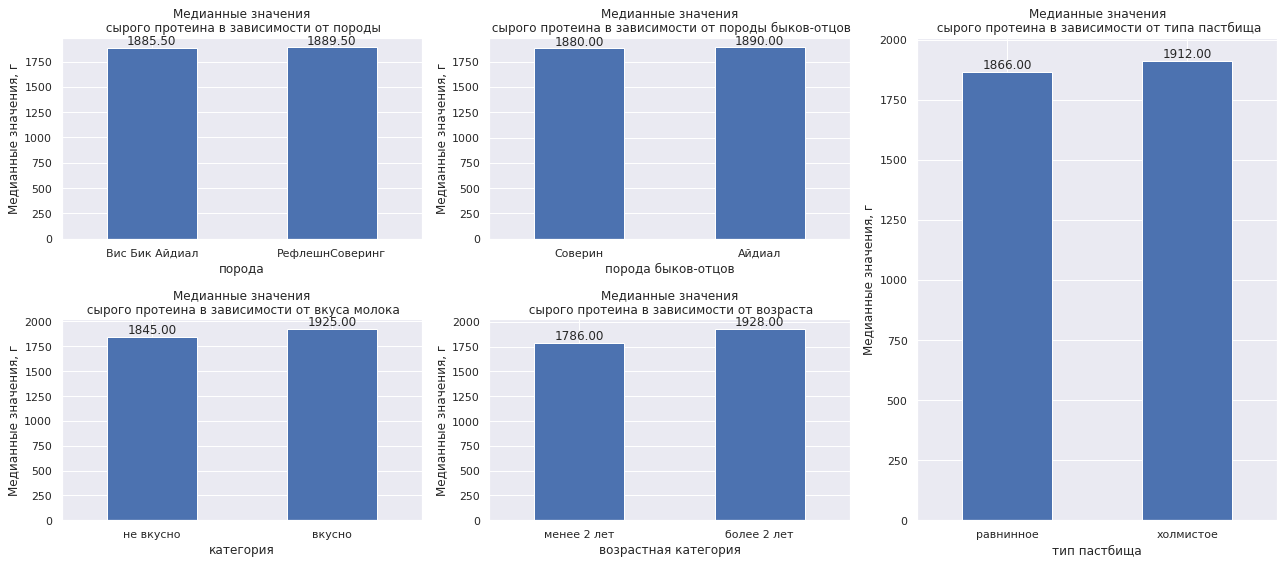

In [510]:
median_estimate(ferma_main, 'raw_protein', 'сырого протеина', 'сырой протеин', 'г', tablerepresent=False, legendbool=False)

Анализ типичных (в данном случае медианных значений) показывает следующее:

- Типичные значения сырого протеина в зависимости от породы почти одинаковые, однако чуть выше для молока коров проды `РефлешнСоверин`
- Сырого протеина больше у молока потомков пап-быков породы `Айдиал`
- Типичное значение сырого протеина во вкусном молоке больше чем в невкусном (разница довольно большая)
- Коровы постарше дают молоко с большим значением сырого протеина
- Коровы холмистых пастбищ дают молоко с большим содержанием сырого протеина

#### Работа со столбцом `breed` (Порода)

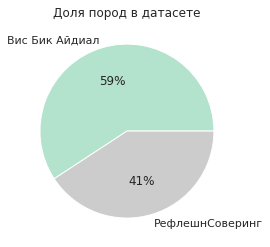

In [511]:

(ferma_main
 .breed
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       title='Доля пород в датасете',
               colormap='Pastel2'
      ))
plt.show()

- Оказывается, что в данных почти `60%` коров породы `Вик Бик Айдиал`

In [512]:
ferma_main.pivot_table(index=['breed', 'pasture_type'], values=['raw_protein', 'milk_yield'], aggfunc=['median'])

median            
                             milk_yield raw_protein
breed           pasture_type                       
Вис Бик Айдиал  равнинное        6030.0      1861.0
                холмистое        6153.0      1914.0
РефлешнСоверинг равнинное        6116.0      1867.0
                холмистое        6246.0      1908.0

- Наибольший типичный удой наблюдается для коров породы `РефлешнСоверинг` на холмистых пастбищах, наименьший типичный удой у коров породы `Вис Бик Айдиал` на равнинных пастбищах
- Для типичного значения сырого протеина: максимальные значения для коров породы `Вис Бик Айдиал` на холмистых пастбищах, минимальные - у коров породы `Вис Бик Айдиал` на равнинных пастбищах

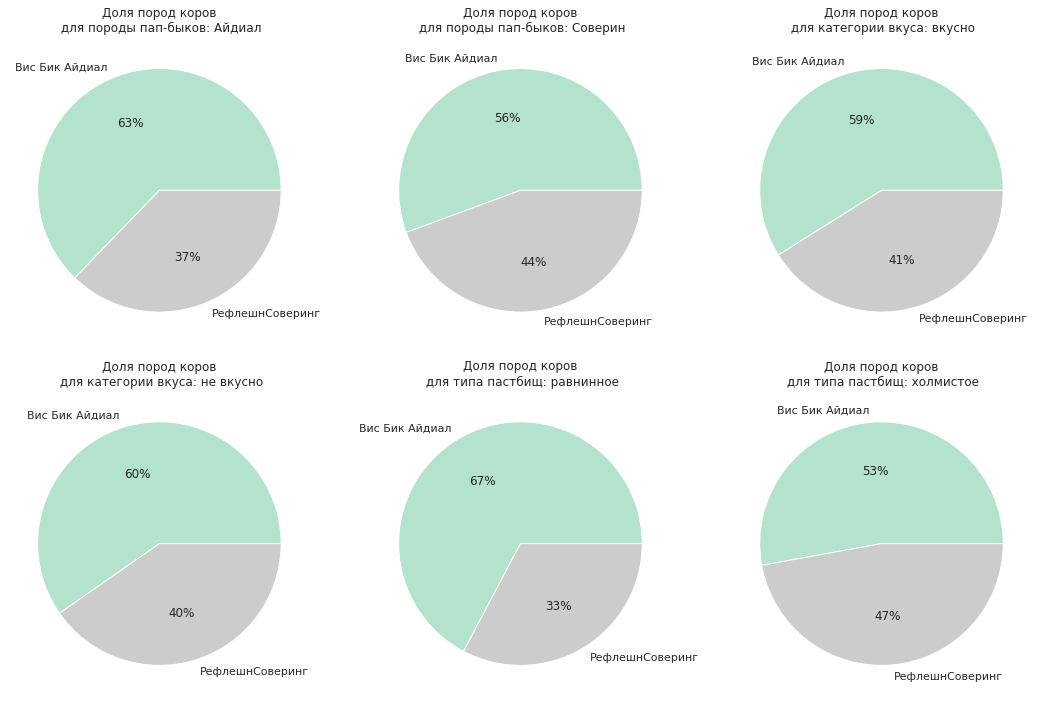

In [513]:
categories = {
    "породы пап-быков": ("father_breed", ferma_main.father_breed.unique(), 0),
    "категории вкуса": ("milk_taste", ferma_main.milk_taste.unique(), 2),
    "типа пастбищ": ("pasture_type", ferma_main.pasture_type.unique(), 4),    
}

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()
# pies(ferma_main, ax, 'breed', 'Доля пород коров', categories)
pies_or_bars(ferma_main, ax, 'breed', 'Доля пород коров', categories)

- Причем доля коров этой породы (`Вик Бик Айдиал`) превалирует на всех типах пастбищ (особенно на равнинных пастбищах, более чем в два раза)
- По вкусу молока доли пород коров приблизительно равны (60% `Вик Бик Айдиал`, 40% - `РефлешнСоверинг`)
- Интересно, для коров где папа-бык представляет породу `Соверин`, порода `Вис Бик Айдиал` также превалирует

#### Работа со столбцом `spo` (СПО)

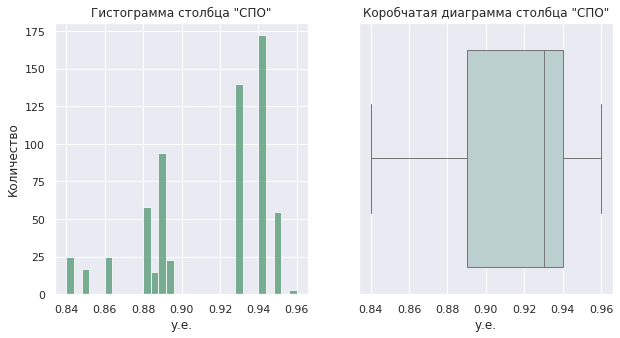

In [514]:
plot_graphics(ferma_main, 'spo', col_alias='"СПО"', xlabel='у.е.')

Очень любопытный "коридор" между 0.9 и 0.93. Попробуем категоризовать данные

In [515]:
ferma_main['spo_category'] = ferma_main['spo'].apply(lambda x: 'spo $\leqslant$ 0.91' if  x <= .91 else 'spo > 0.91')

In [516]:
ferma_main.pivot_table(index='spo_category', values=['milk_yield'], aggfunc=['min', 'max'])

min        max
                     milk_yield milk_yield
spo_category                              
spo $\leqslant$ 0.91       5204       5998
spo > 0.91                 6005       7222

Практически бесшовно максимум одной категории предшествует минимуму другой категории

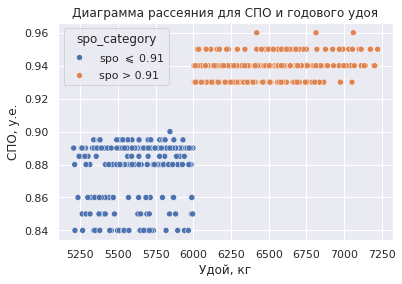

In [517]:
g = sns.scatterplot(
    data=ferma_main,
    x='milk_yield', 
    y='spo',
    hue='spo_category'
)
    # hue='категория ЭКЕ')
g.set_title('Диаграмма рассеяния для СПО и годового удоя')
g.set_xlabel('Удой, кг')
g.set_ylabel('CПО, у.е.')

plt.show()

Действительно, можно линией разделить данные с высоким значением удоя, которые будут соответствовать высоким значениям СПО

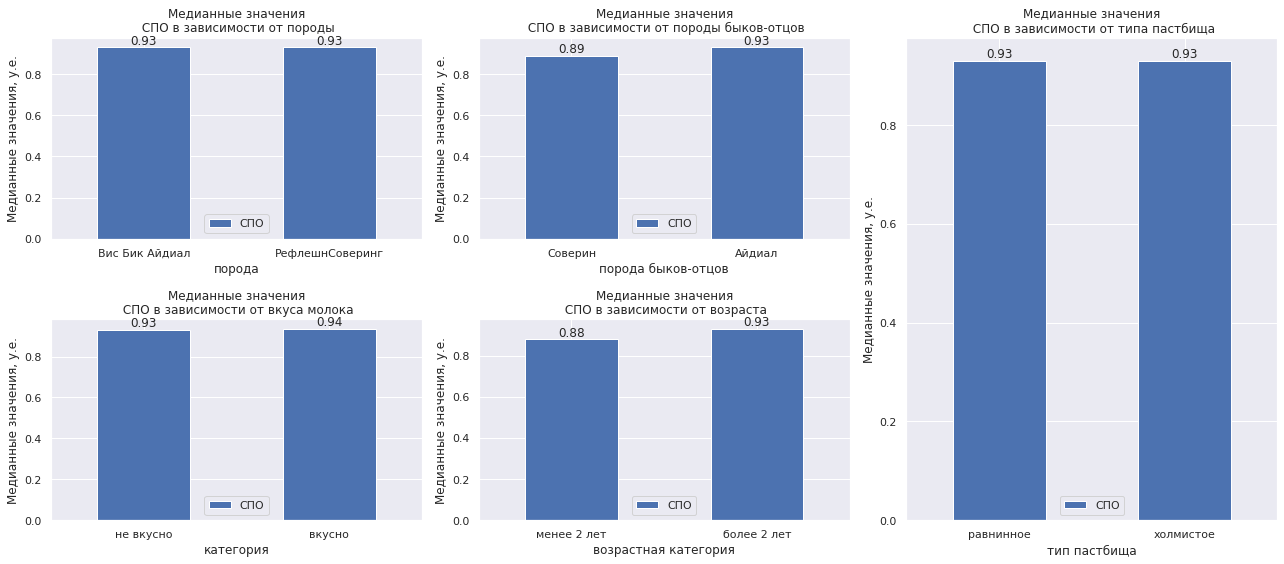

In [518]:
median_estimate(ferma_main, 'spo', 'СПО', 'СПО', 'у.е.', tablerepresent=False)

Анализ типичных (в данном случае медианных значений) показывает следующее:

- Типичное значение СПО не зависит от породы коровы
- Но СПО выше у молока коров от папы-быка породы `Айдиал`
- Почти не зависят значения СПО от вкусовой категории (хотя у вкусного молока немного повыше)
- Коровы постарше дают молоко с большим значением СПО
- Типичное значение СПО не зависит от типа пастбища

In [519]:
ferma_main.pivot_table(index=['spo_category'], values='milk_yield', aggfunc=['median'])

median
                     milk_yield
spo_category                   
spo $\leqslant$ 0.91     5669.0
spo > 0.91               6452.5

In [520]:
ferma_main.pivot_table(index=['spo_category', 'breed'], values=['milk_yield'], aggfunc=['median'])

median
                                     milk_yield
spo_category         breed                     
spo $\leqslant$ 0.91 Вис Бик Айдиал      5647.0
                     РефлешнСоверинг     5693.0
spo > 0.91           Вис Бик Айдиал      6410.0
                     РефлешнСоверинг     6478.5

- Наибольшие удои молока с высоким значением СПО от коров породы `РефлешнСоверинг`
- Наименьшие удои молока с низким значением СПО от коров породы `Вис Бик Айдиал`

In [521]:
ferma_main.pivot_table(index=['pasture_type', 'spo_category'], values='milk_yield', aggfunc=['median'])

median
                                  milk_yield
pasture_type spo_category                   
равнинное    spo $\leqslant$ 0.91     5641.0
             spo > 0.91               6418.0
холмистое    spo $\leqslant$ 0.91     5689.0
             spo > 0.91               6463.5

- Наибольшие удои молока с высоким значением СПО на холмистых пастбищах
- Наименьшие удои молока с низким значением СПО от на равнинных пастбищах

In [522]:
ferma_main.pivot_table(index=['milk_taste', 'spo_category'], values='milk_yield', aggfunc=['median'])

median
                                milk_yield
milk_taste spo_category                   
вкусно     spo $\leqslant$ 0.91     5698.0
           spo > 0.91               6458.0
не вкусно  spo $\leqslant$ 0.91     5613.5
           spo > 0.91               6410.5

- Наибольшие удои вкусного молока с высоким значением СПО
- Наименьшие удои невкусного молока с низким значением СПО 

In [523]:
ferma_main.pivot_table(index=['father_breed', 'spo_category'], values='milk_yield', aggfunc=['median'])

median
                                  milk_yield
father_breed spo_category                   
Айдиал       spo $\leqslant$ 0.91     5712.0
             spo > 0.91               6557.0
Соверин      spo $\leqslant$ 0.91     5638.5
             spo > 0.91               6304.0

- Наибольшие удои молока с высоким значением СПО у коров, папы-быки которых имеют породу `Айдиал`
- Наименьшие удои молока с низким значением СПО у коров, папы-быки которых имеют породу `Соверин`
- Внутри `spo_category` значения достаточно сильно изменяются (разница между удоями разных пород пап-быков около 100 кг)

#### Работа со столбцом `pasture_type` (Тип пастбища)

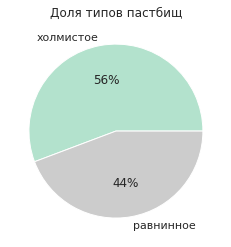

In [524]:
(ferma_main
 .pasture_type
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       title=f'Доля типов пастбищ',
               colormap='Pastel2'
      ))
plt.show()

- Из диаграммы видим, что холмистые пастбища превалируют над равнинными

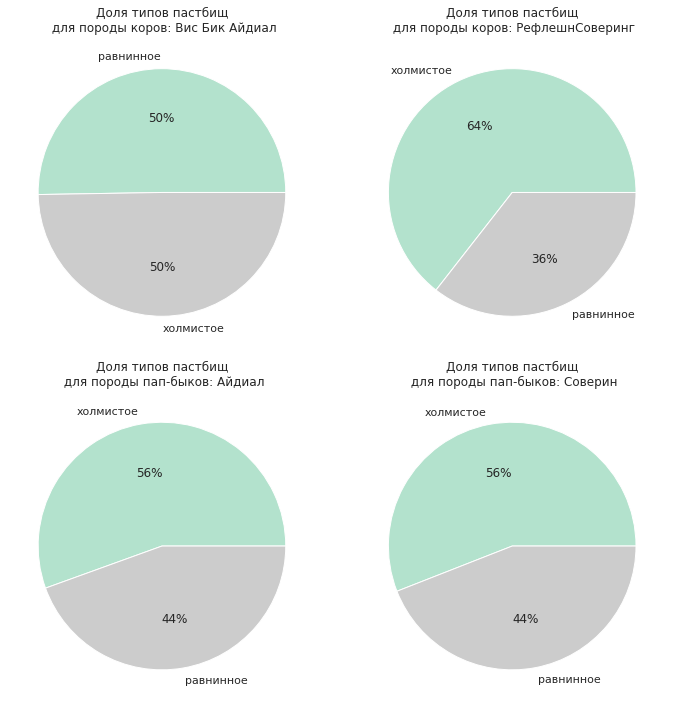

In [525]:
categories = {
    "породы коров": ("breed", ferma_main.breed.unique(), 0),
    "породы пап-быков": ("father_breed", ferma_main.father_breed.unique(), 2),
}

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

pies_or_bars(ferma_main, ax, 'pasture_type', 'Доля типов пастбищ', categories)

- Порода коров `Вис Бик Айдиал` представлена в данных сбалансировано в отношении типа пастбищ
- А порода `РефлешнСоверинг` больше представлены на холмистых пастбищах
- По признаку породы папы-быка доли пастбищ совпадают (`56%` - холмистые, `44%` - равнинные)

In [526]:
ferma_main.pivot_table(index=['pasture_type'], values=['raw_protein', 'milk_yield', 'efu', 'spo', 'protein'], aggfunc='median')

efu  milk_yield  protein  raw_protein   spo
pasture_type                                              
равнинное     14.6      6061.0    3.075       1866.0  0.93
холмистое     14.8      6171.0    3.076       1912.0  0.93

- Медианные значения ЭКЕ, годового удоя, сырого протеина, процента белка и СПО выше у молока коров, пасущихся на холмистых пастбищах

#### Работа со столбцом `father_breed` (порода папы-быка)

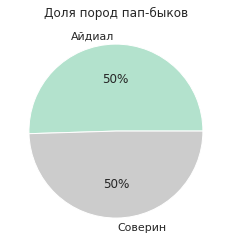

In [527]:

(ferma_main
 .father_breed
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       title='Доля пород пап-быков',
               colormap='Pastel2'
      ))


plt.show()

- Видим сбалансированность по породам пап-быков в данных

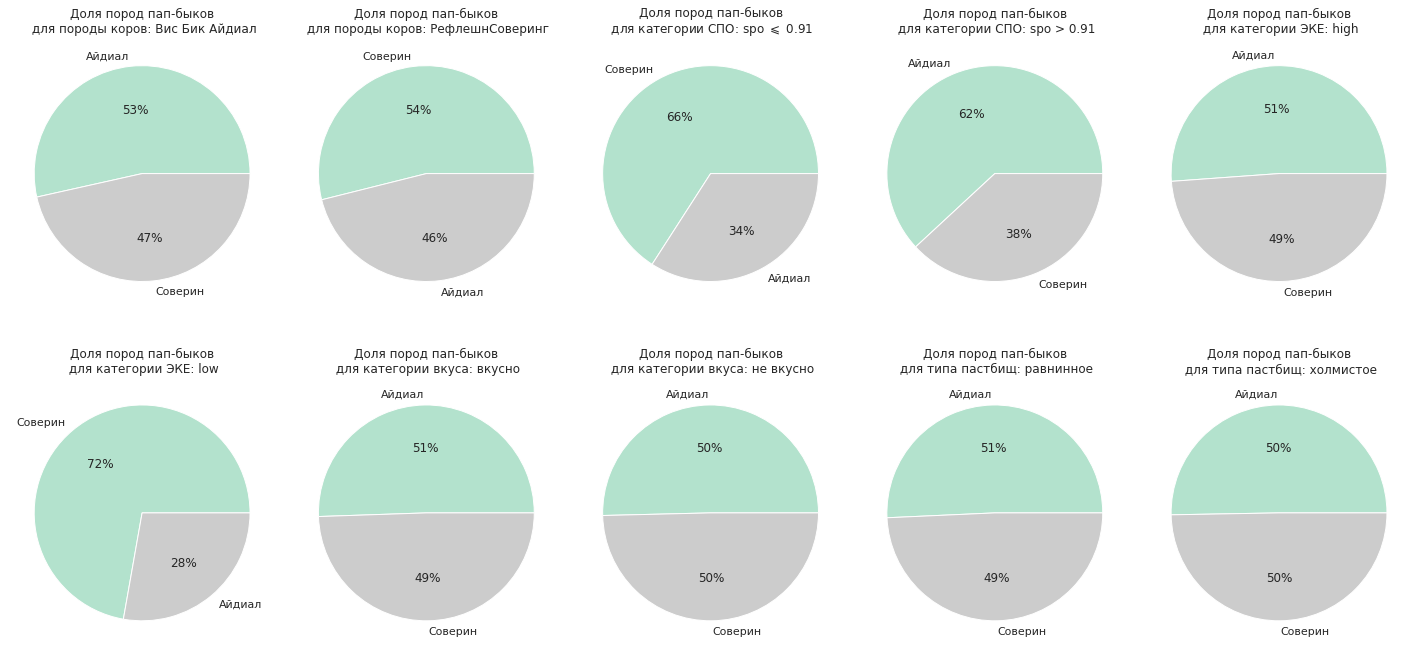

In [528]:
categories = {
    "породы коров": ("breed", ferma_main.breed.unique(), 0),
    "категории СПО": ("spo_category", ferma_main.spo_category.unique(), 2),
    "категории ЭКЕ": ("efu_category", ferma_main.efu_category.unique(), 4),
    "категории вкуса": ("milk_taste", ferma_main.milk_taste.unique(), 6), 
    "типа пастбищ": ("pasture_type", ferma_main.pasture_type.unique(), 8),    
    
}

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.flatten()

pies_or_bars(ferma_main, ax, 'father_breed', 'Доля пород пап-быков', categories)

- `53%` коров породы `Виск Бик Айдиал` имеют в родителях папу-быка породы `Айдиал`
- `54%` коров породы `РефлешнСоверин` имеют в родителях папу-быка породы `Cоверин`
- Малые значения СПО молока присущи коровам, имеющим в предках быка породы `Cоверин`
- Большие значения СПО молока присущи коровам, имеющим в предках быка породы `Айдиал`
- Категория значений ЭКЕ практически не зависит от породы папы-быка, как и вкусовая категория
- Причем в разрезе типов пастбищ также наблюдается сбалансированность

In [529]:
ferma_main.pivot_table(index=['father_breed'], values=['raw_protein', 'milk_yield', 'efu', 'spo'], aggfunc='median')

efu  milk_yield  raw_protein   spo
father_breed                                     
Айдиал        14.7      6370.0       1890.0  0.93
Соверин       14.6      5919.0       1880.0  0.89

- Молоко коров, чьими отцами являются быки породы `Айдиал` имеет `efu`, `milk_yield`, `raw_protein`, `spo` в среднем большие значения чем молоко коров, чьими предками являются быки породы `Соверин`

#### Работа со столбцом `fat_content` (Жирность)

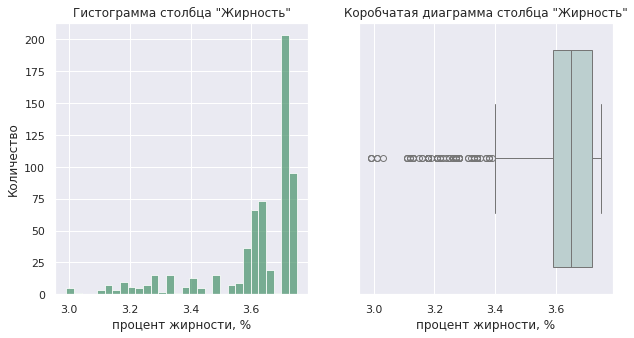

In [530]:
plot_graphics(ferma_main, 'fat_content', col_alias='"Жирность"', xlabel='процент жирности, %')

In [531]:
ferma_main['fat_category'] = ferma_main['fat_content'].apply(lambda x: 'fat $\leqslant$ 3.7' if  x <= 3.7 else 'fat > 3.7')

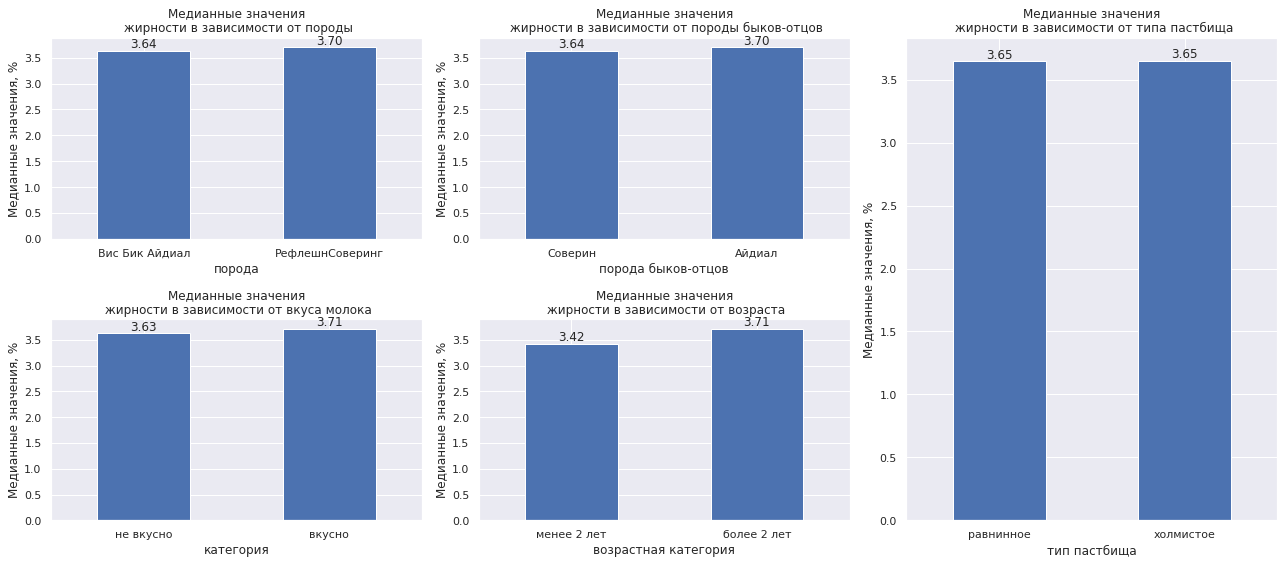

In [532]:
median_estimate(ferma_main, 'fat_content', 'жирности', 'Жирность', '%', tablerepresent=False, legendbool=False)

In [533]:
ferma_main.pivot_table(index='fat_category', values=['raw_protein', 'milk_yield', 'efu', 'spo', 'fat_content'], aggfunc='median')

efu  fat_content  milk_yield  raw_protein   spo
fat_category                                                         
fat $\leqslant$ 3.7  13.7         3.61      5784.0       1818.0  0.89
fat > 3.7            15.6         3.72      6480.0       1985.0  0.94

Анализ типичных (в данном случае медианных значений) показывает следующее:

- Типичное значение жирности выше у молока коров `РефлешнСоверинг`
- Но жирность выше у молока коров от папы-быка породы `Айдиал`
- Вкусное молоко в среднем имеет большую жирность
- Коровы постарше дают более жирное молоко
- Типичное значение жирности не зависит от типа пастбища


- Медианные удои более жирного молока выше, так же как и другие показатели

#### Работа со столбцом `protein` (белок)

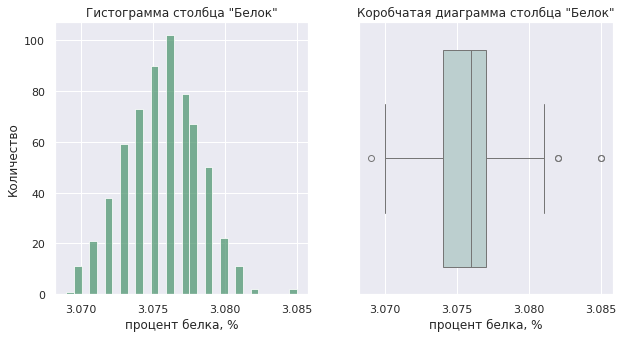

In [534]:
plot_graphics(ferma_main, 'protein', col_alias='"Белок"', xlabel='процент белка, %')

In [535]:
median_estimate(ferma_main, 'protein', 'белка', 'Белок', '%', tablerepresent=True)

protein
breed                   
РефлешнСоверинг    3.075
Вис Бик Айдиал     3.076

protein
father_breed         
Айдиал          3.076
Соверин         3.076

protein
milk_taste         
не вкусно     3.075
вкусно        3.076

protein
age                 
более 2 лет    3.076
менее 2 лет    3.076

In [536]:
ferma_main.pivot_table(index='spo_category', values='protein', aggfunc='median')

protein
spo_category                 
spo $\leqslant$ 0.91    3.076
spo > 0.91              3.076

In [537]:
ferma_main.pivot_table(index='efu_category', values='protein', aggfunc='median')

protein
efu_category         
high            3.076
low             3.076

- Видим, что уровень белка практически не зависит от породы, породы отца-быка, вкуса и возраста
- Не зависит уровень белка и от категорий ЭКЕ и СПО

#### Работа со столбцом `milk_taste` (вкус молока)

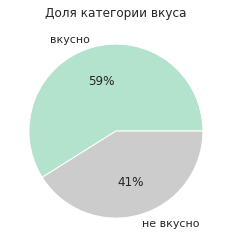

In [538]:

(ferma_main
 .milk_taste
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       title='Доля категории вкуса',
               colormap='Pastel2'
      ))

plt.show()

- Удоя вкусного молока все таки больше, хотя невкусного молока около 40%, что вряд ли является самым лучшим показателем

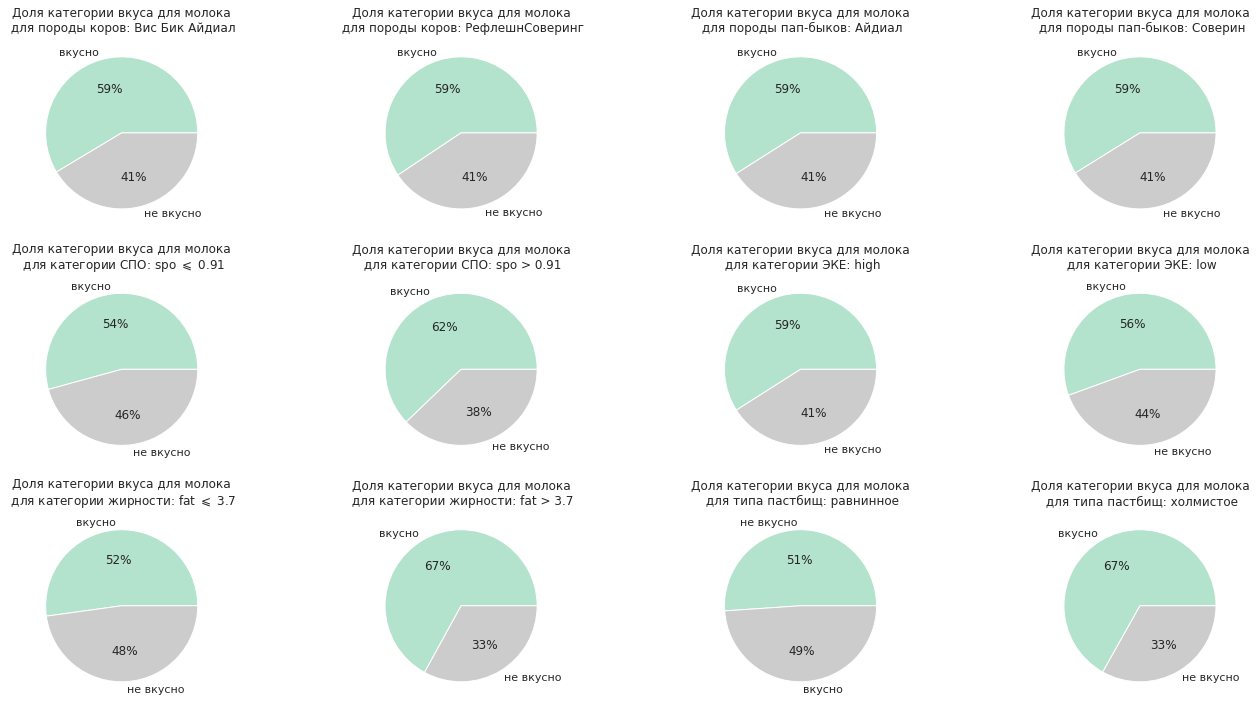

In [539]:
categories = {
    "породы коров": ("breed", ferma_main.breed.unique(), 0),
    "породы пап-быков": ("father_breed", ferma_main.father_breed.unique(), 2),
    "категории СПО": ("spo_category", ferma_main.spo_category.unique(), 4),
    "категории ЭКЕ": ("efu_category", ferma_main.efu_category.unique(), 6),
    "категории жирности": ("fat_category", ferma_main.fat_category.unique(), 8),
    "типа пастбищ": ("pasture_type", ferma_main.pasture_type.unique(), 10),    
    
}

fig, ax = plt.subplots(3, 4, figsize=(20, 10))
ax = ax.flatten()

pies_or_bars(ferma_main, ax, 'milk_taste', 'Доля категории вкуса для молока', categories)

- Для пород коров и пород пап-быков соотношение вкусное/невкусное одно и то же (60/40)
- В разрезе категории СПО:
    - Для низких значений `СПО` около `54%` молока вкусное
    - Для высоких значнеий `СПО` вкусного молока уже `62%`
- Для малых значений `ЭКЕ` большая часть молока невкусная
- А вот для высоких значений `ЭКЕ` уже около `70%` вкусного молока
- Более жирное молоко явно вкуснее, а вот молоко умеренной жирности колеблется на пороге 50/50
- Интересно, что на равнинных пастбищах большая часть удоя представляет собой невкусное молоко...
- А вот на холмистых пастбищах около 2/3 всего удоя - вкусное молоко

In [540]:
ferma_main.pivot_table(index=['milk_taste'], values=['raw_protein', 'milk_yield', 'efu', 'spo', 'fat_content'], aggfunc='median')

efu  fat_content  milk_yield  raw_protein    spo
milk_taste                                                   
вкусно      15.0         3.71      6166.0       1925.0  0.935
не вкусно   14.2         3.63      6061.5       1845.0  0.930

- У вкусного молока все медианные показатели `сырой протеин`, `удой`, `ЭКЕ`, `СПО`, `жирность` больше чем у невкусного 

#### Работа со столбцом `age` (возрастная категория)

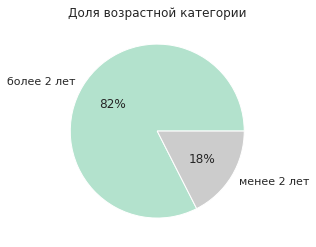

In [541]:

(ferma_main
 .age
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       title='Доля возрастной категории',
               colormap='Pastel2'
      ))

plt.show()

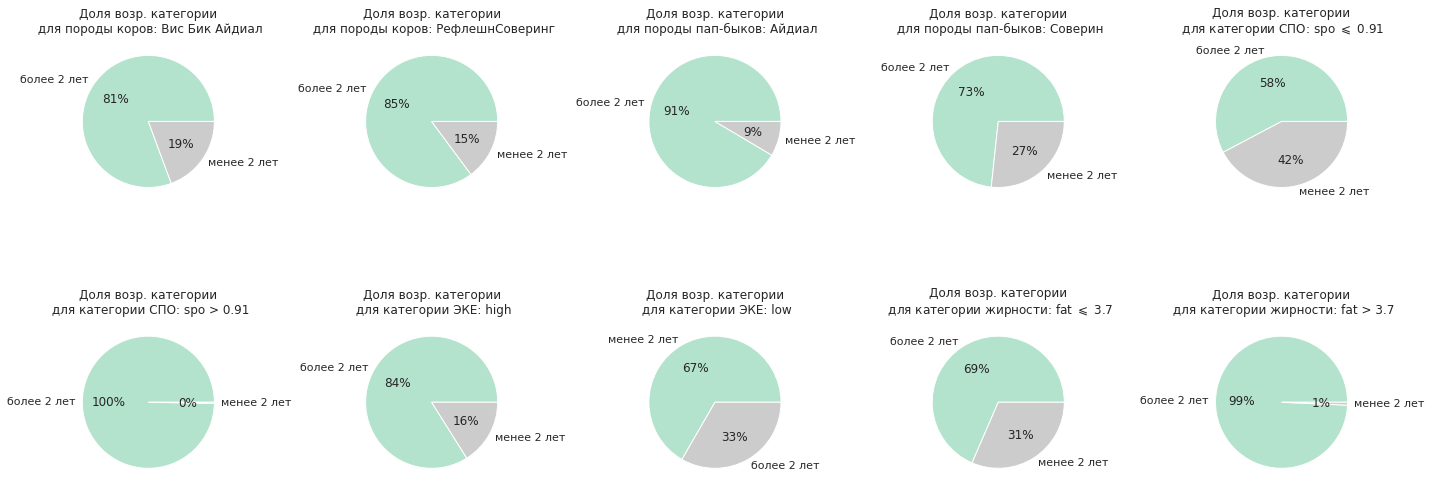

In [542]:
categories = {
    "породы коров": ("breed", ferma_main.breed.unique(), 0),
    "породы пап-быков": ("father_breed", ferma_main.father_breed.unique(), 2),
    "категории СПО": ("spo_category", ferma_main.spo_category.unique(), 4),
    "категории ЭКЕ": ("efu_category", ferma_main.efu_category.unique(), 6),   
    "категории жирности": ("fat_category", ferma_main.fat_category.unique(), 8),
}

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
ax = ax.flatten()

pies_or_bars(ferma_main, ax, 'age', 'Доля возр. категории', categories)

- В данных больше возрастных коров
- По каждой породе молодых коров менее `20%`
- Более четверти молодых коров - потомки быков породы `Соверин`
- Малые значения `СПО` достаточно широко представлены в категории молодых коров (около `42%`)
- А вот высоких значений `СПО` у молодых коров практически нет
- Почти треть молодых коров имеют малые значения `ЭКЕ`
- Почти все коровы (`99%`), молоко которых имеет высокое значение `СПО` - возрастные
- Возрастные коровы дают более жирное молоко (около `99%`)
- Треть молодых коров дает удой молока с низким содержанием жира

Портреты удоя коров разной породы

- `Вис Бик Айдиал`
    - Доля породы в данных - `60%`
    - Медианный удой - `6112.5 кг`
    - В категории низких значений ЭКЕ при распределении по породам доля коров этой породы составляет около `80%`
    - Медианные значения сырого протеина удоя молока коров этой породы несколько ниже чем у `РефлешнСоверинг` (`1885 г`)
    - Доля коров этой породы (`Вик Бик Айдиал`) превалирует на всех типах пастбищ (особенно на равнинных пастбищах, более чем в два раза)
    - В разрезе вкуса молока 60% коров этой породы имеют невкусное молоко и также  60%  коров этой породы имеет вкусное молоко
    - Интересно, что порода папы-быка `Соверин` превалирует также и для коров породы `Вис Бик Айдиал`, а также среди потомков быков породы `Айдиал` большинство коров имеют породу `Вис Бик Айдиал`
    - СПО молока коров этой породы составляе `0.93`
    - Однако распределение долей пастбищ для коров этой породы сбалансированно (50/50)
    - `53%` коров породы `Вис Бик Айдиал` имеют в родителях папу-быка породы `Айдиал`
    - Медианное значение уровня жирности ниже чем у молока коров породы `РефлешнСоверинг`
    - Медианный уровень белка составляет `3.076`
    - Около `20%` коров этой породы молодые (менее 2 лет)


- `РефлешнСоверинг`
    - Медианный удой - `6178.5 кг`
    - В категории низких значений ЭКЕ при распределении по породам доля коров этой породы составляет около `20%`
    - Медианные значения сырого протеина удоя молока коров этой породы несколько ниже чем у `РефлешнСоверинг` (`1889.5 г`)
    - Доля коров этой породы (`РефлешнСоверинг`) на равнинных пастбищ составляет `33%`, на холмистых - `47%`
    - В разрезе вкуса молока 40% коров этой породы имеют невкусное молоко и также `40%`  коров этой породы имеет вкусное молоко
    - Доля коров этой породы среди коров, имеющих отца-быка породы `Айдиал` составляет `37%`, среди имеющих отца-быка породы `Соверин` - `44%`
    - СПО молока коров этой породы составляе `0.93`
    - Распределение долей пастбищ для коров этой породы несбалансированное (`64%` - `холмистые`, `36%` - `равнинные`)
    - `54%` коров породы `РефлешнСоверинг` имеют в родителях папу-быка породы `Соверин`
    - Медианное значение уровня жирности выше чем у молока коров породы `Вис Бик Айдиал`
    - Медианный уровень белка составляет `3.075`
    - Около `15%` коров этой породы молодые (менее 2 лет)

### Датасет `cow_buy.csv`

In [543]:
cow_buy

breed pasture_type father_breed father_name  \
0    Вис Бик Айдиал    холмистое       Айдиал    Геркулес   
1    Вис Бик Айдиал    равнинное      Соверин      Буйный   
2   РефлешнСоверинг    равнинное      Соверин       Барин   
3   РефлешнСоверинг    холмистое       Айдиал      Буйный   
4   РефлешнСоверинг    равнинное       Айдиал      Буйный   
5   РефлешнСоверинг    равнинное      Соверин    Геркулес   
6    Вис Бик Айдиал    холмистое       Айдиал    Геркулес   
7    Вис Бик Айдиал    равнинное      Соверин      Буйный   
8   РефлешнСоверинг    равнинное      Соверин       Барин   
9   РефлешнСоверинг    холмистое       Айдиал      Буйный   
10   Вис Бик Айдиал    холмистое      Соверин    Соловчик   
11  РефлешнСоверинг    равнинное      Соверин    Геркулес   
12   Вис Бик Айдиал    холмистое       Айдиал    Геркулес   
13   Вис Бик Айдиал    холмистое      Соверин       Барин   
14  РефлешнСоверинг    равнинное      Соверин       Барин   
15  РефлешнСоверинг    холмистое       Айдиал      Буйный   
16   Вис Бик Айдиал    холмистое      Соверин    Соловчик   
17  РефлешнСоверинг    равнинное      Соверин    Геркулес   
18   Вис Бик Айдиал    равнинное      Соверин      Буйный   
19  РефлешнСоверинг    равнинное       Айдиал      Буйный   

    current_fat_content  current_protein_level          age  
0                  3.58                  3.076  более 2 лет  
1                  3.54                  3.081  менее 2 лет  
2                  3.59                  3.074  более 2 лет  
3                  3.40                  3.061  более 2 лет  
4                  3.64                  3.074  более 2 лет  
5                  3.63                  3.053  менее 2 лет  
6                  3.58                  3.076  более 2 лет  
7                  3.57                  3.079  более 2 лет  
8                  3.59                  3.074  более 2 лет  
9                  3.40                  3.079  менее 2 лет  
10                 3.73                  3.055  более 2 лет  
11                 3.73                  3.073  более 2 лет  
12                 3.68                  3.046  более 2 лет  
13                 3.42                  3.075  менее 2 лет  
14                 3.59                  3.074  более 2 лет  
15                 3.40                  3.065  более 2 лет  
16                 3.73                  3.079  более 2 лет  
17                 3.77                  3.053  менее 2 лет  
18                 3.34                  3.069  более 2 лет  
19                 3.64                  3.074  более 2 лет

#### Работа со столбцом `father_breed`

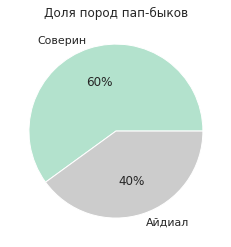

In [544]:
(cow_buy
 .father_breed
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       title='Доля пород пап-быков',
               colormap='Pastel2'
      ))
plt.show()

- Преобладает порода папы-быка `Соверин`

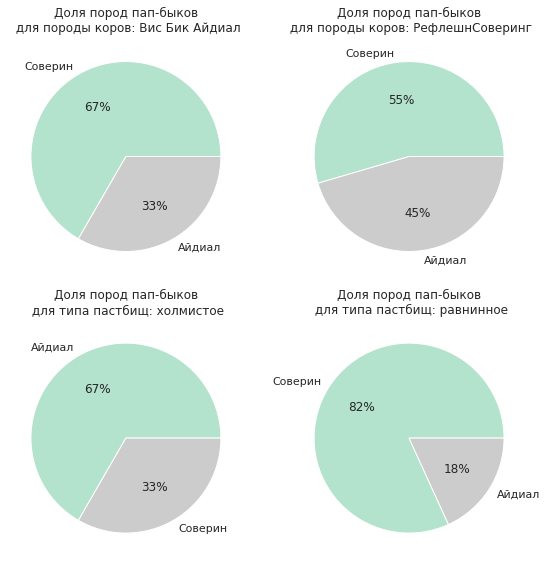

In [545]:
categories = {
    "породы коров": ("breed", cow_buy.breed.unique(), 0),
    "типа пастбищ": ('pasture_type', cow_buy.pasture_type.unique(), 2)    
    
}

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()

pies_or_bars(cow_buy, ax, 'father_breed', 'Доля пород пап-быков', categories)

- У коров породы `Виск Бик Айдиал` в отцах-быках преобладает порода `Соверин` (`67%`)
- А для `РефлешнСоверинг` все практически сбалансированно
- Коровы, чьими отцами являются быки породы `Айдиал` больше представлены на холмистых пастбищах
- На равнинных пастбищах больше коров, чьими родителями являются быки породы `Соверин` (`82%`)

In [546]:
cow_buy.pivot_table(index='father_breed', values=['current_fat_content', 'current_protein_level'], aggfunc='median')

current_fat_content  current_protein_level
father_breed                                            
Айдиал                       3.58                  3.074
Соверин                      3.59                  3.074

#### Работа со столбцами `pasture_type`

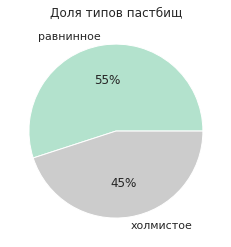

In [547]:
(cow_buy
 .pasture_type
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       title=f'Доля типов пастбищ',
               colormap='Pastel2'
      ))
plt.show()

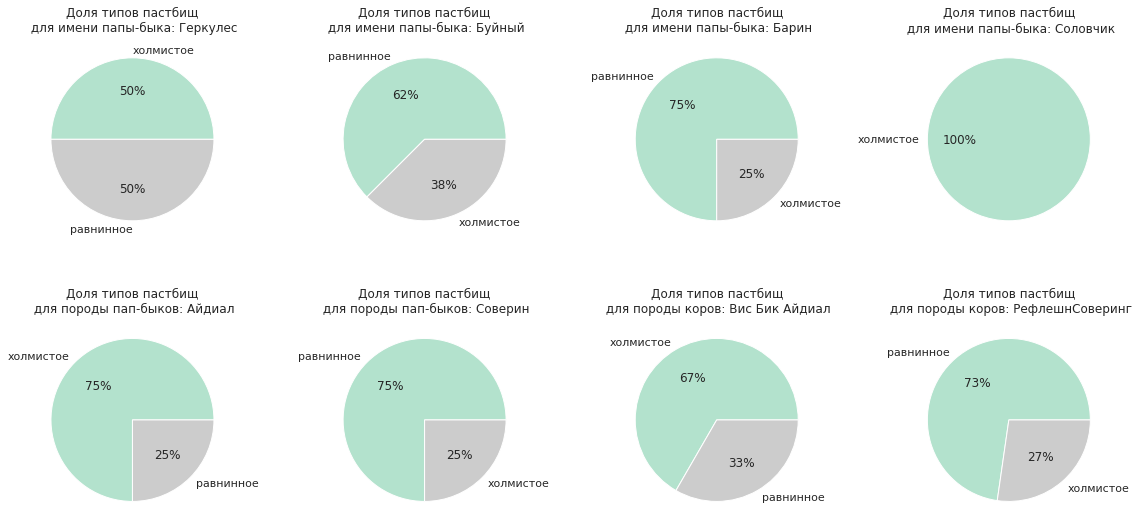

In [548]:
categories = {
    "имени папы-быка": ("father_name", cow_buy.father_name.unique(), 0),    
    "породы пап-быков": ("father_breed", cow_buy.father_breed.unique(), 4),    
    "породы коров": ("breed", cow_buy.breed.unique(), 6),
}

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.flatten()

pies_or_bars(cow_buy, ax, 'pasture_type', 'Доля типов пастбищ', categories)

- Коровы, чьим отцом является `Геркулес`, больше представлены на `равнинных` пастбищах
- Коровы, чьим отцом является `Буйный`, больше представлены на `равнинных` пастбищах
- Коровы, чьим отцом является `Барин`, равновелико представлены на всех типах пастбищ
- Коровы, чьим отцом является `Соловчик` представлены исключительно на `холмистых` пастбищах
- Коровы, чьим отцом является бык породы `Айдиал`, больше представлены на `холмистых` пастбищах (`75%`)
- Коровы, чьим отцом является бык породы `Соверин`, больше представлены на `равнинных` пастбищах (`75%`)






#### Работа со столбцами `father_name`

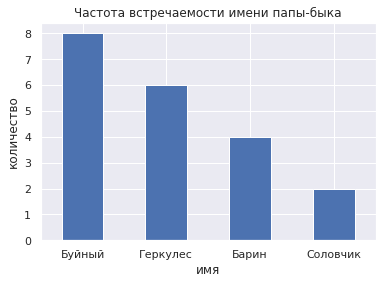

In [549]:
ax = (cow_buy['father_name']
 .value_counts()
 .plot(kind='bar',
       title='Частота встречаемости имени папы-быка'
      ))
plt.xticks(rotation=0)
plt.ylabel('количество')
plt.xlabel('имя')
plt.show()


- Самое популярное имя быка - `Буйный`
- Наименее популярно имя - `Соловчик`

In [550]:
(cow_buy
 .pivot_table(index=['father_name', 'father_breed'], values='age', aggfunc='count')
 .reset_index()
 .set_axis(['Имя папы-быка', 'Порода папы-быка', 'количество'], axis=1)
 .set_index(['Имя папы-быка', 'Порода папы-быка']))

количество
Имя папы-быка Порода папы-быка            
Барин         Соверин                    4
Буйный        Айдиал                     5
              Соверин                    3
Геркулес      Айдиал                     3
              Соверин                    3
Соловчик      Соверин                    2

- Быки с именем `Буйный` представлены в данных наиболее широко в породе `Айдиал`
- Все быки с именем `Соловчик` имеют породу `Соверин`

#### Работа со столбцами `age`

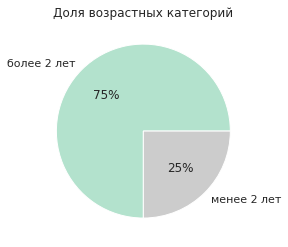

In [551]:
(cow_buy
 .age
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       title=f'Доля возрастных категорий',
               colormap='Pastel2'
      ))
plt.show()

In [552]:
(cow_buy
 .pivot_table(index=['age', 'father_name'], values='breed', aggfunc='count')
 .reset_index()
 .set_axis(['возрастная категория', 'имя папы-быка', 'количество'], axis=1)
 .set_index(['возрастная категория', 'имя папы-быка']))

количество
возрастная категория имя папы-быка            
более 2 лет          Барин                   3
                     Буйный                  6
                     Геркулес                4
                     Соловчик                2
менее 2 лет          Барин                   1
                     Буйный                  2
                     Геркулес                2

In [553]:
(cow_buy
 .pivot_table(index=['age', 'father_breed'], values='breed', aggfunc='count')
 .reset_index()
 .set_axis(['возрастная категория', 'порода папы-быка', 'количество'], axis=1)
 .set_index(['возрастная категория', 'порода папы-быка']))

количество
возрастная категория порода папы-быка            
более 2 лет          Айдиал                     7
                     Соверин                    8
менее 2 лет          Айдиал                     1
                     Соверин                    4

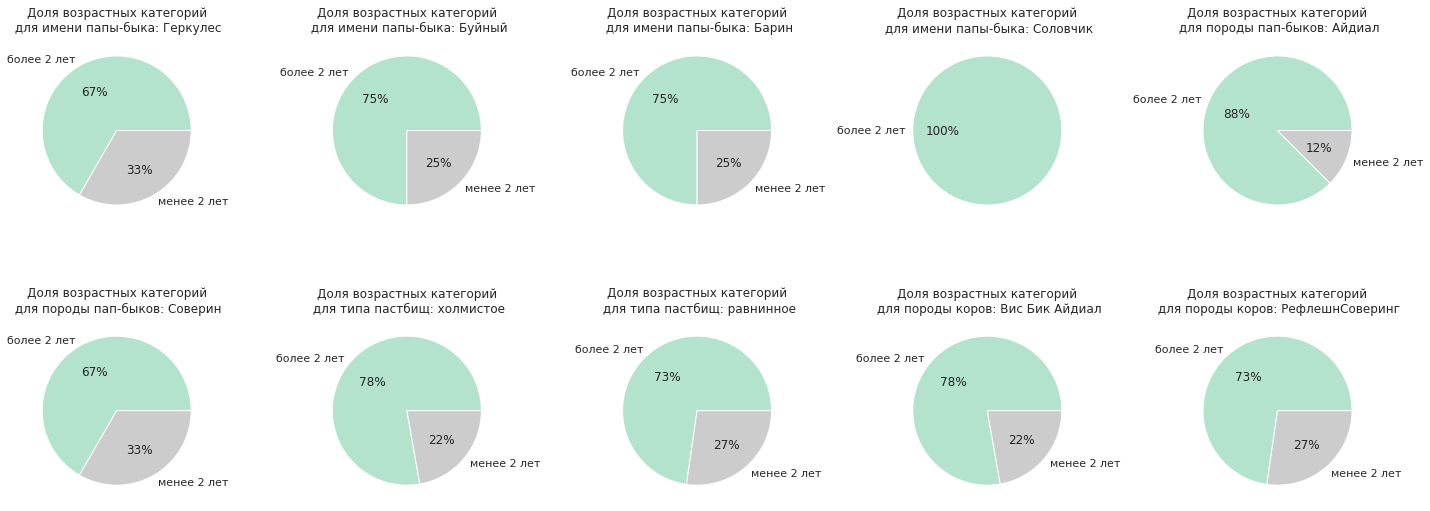

In [554]:
categories = {
    "имени папы-быка": ("father_name", cow_buy.father_name.unique(), 0),    
    "породы пап-быков": ("father_breed", cow_buy.father_breed.unique(), 4), 
    "типа пастбищ": ("pasture_type", cow_buy.pasture_type.unique(), 6),    
    "породы коров": ("breed", cow_buy.breed.unique(), 8),
    
    
}

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
ax = ax.flatten()

pies_or_bars(cow_buy, ax, 'age', 'Доля возрастных категорий', categories)

- В данных большая часть коров - `взрослые`
- Коровы, чьим отцом является бык с именем `Геркулес` больше представлены в категории - `более 2 лет`
- Коровы, чьим отцом является бык с именем `Буйный` больше представлены в категории - `более 2 лет`
- Коровы, чьим отцом является бык с именем `Барин` сбалансированно представлены в рамках возрастной категории
- Коровы, чьим отцом является бык с именем `Соловчик` представлены тольк в категории - `более 2 лет`
- Коровы, чьим отцом является бык породы `Айдиал` больше представлены в категории - `более 2 лет` (`88%`)
- Коровы, чьим отцом является бык породы `Соверин` больше представлены в категории - `более 2 лет` (`67%`)
- Коровы, пасущиеся на холмах больше представлены в категории - `более 2 лет` (`78%`)
- Коровы, пасущиеся на равнинах больше представлены в категории - `более 2 лет` (`73%`)

#### Работа со столбцом `breed`

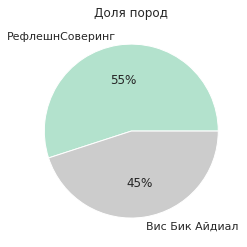

In [555]:
(cow_buy
 .breed
 .value_counts()
 .plot(kind='pie',
       autopct="%.0f%%",
       ylabel="",
       title=f'Доля пород',
               colormap='Pastel2'
      ))
plt.show()

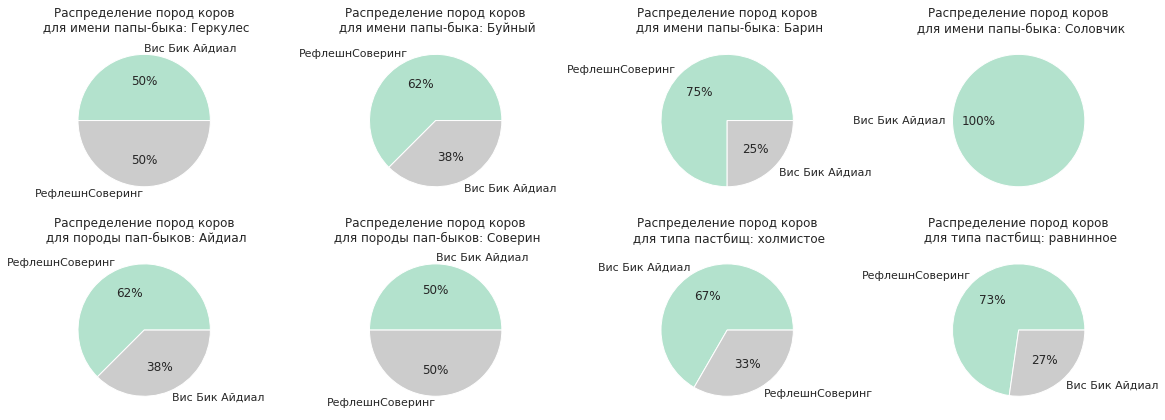

In [556]:
categories = {
    "имени папы-быка": ("father_name", cow_buy.father_name.unique(), 0),    
    "породы пап-быков": ("father_breed", cow_buy.father_breed.unique(), 4), 
    "типа пастбищ": ("pasture_type", cow_buy.pasture_type.unique(), 6),    
}

fig, ax = plt.subplots(2, 4, figsize=(16, 6))
ax = ax.flatten()

pies_or_bars(cow_buy, ax, 'breed', 'Распределение пород коров', categories, 'pie')

- В данных часть коровы равновелико представлены по всем породам
- Коровы, чьим отцом является бык с именем `Геркулес`,  сбалансированы по породам
- Коровы, чьим отцом является бык с именем `Буйный`, больше представлены в породе - `РефлешнСоверин` (`62%`)
- Коровы, чьим отцом является бык с именем `Барин`, больше представлены в породе - `РефлешнСоверин` (`75%`)
- Коровы, чьим отцом является бык с именем `Соловчик`, представлены только в породе - `Вис Бик Айдиал`
- Коровы, чьим отцом является бык породы `Айдиал`, больше представлены в породе - `РефлешнСоверин` (`62%`)
- Коровы, чьим отцом является бык породы `Соверин`, сбалансированы по породам
- Коровы, пасущиеся на холмах больше представлены в породе - `Вис Бик Айдиал` (`67%`)
- Коровы, пасущиеся на равнинах больше представлены в породе - `РефлешнСоверин` (`73%`)

#### Работа со столбцом `current_fat_content`

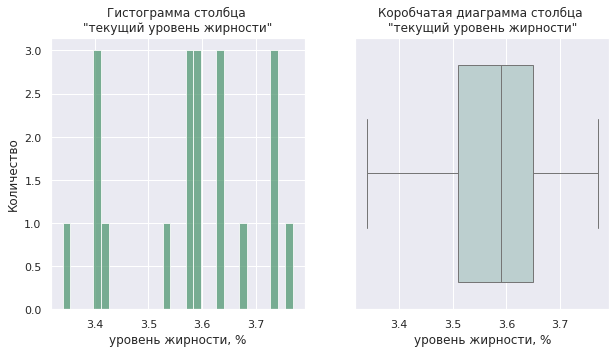

In [557]:
plot_graphics(cow_buy, 'current_fat_content', col_alias='\n"текущий уровень жирности"', xlabel='уровень жирности, %')

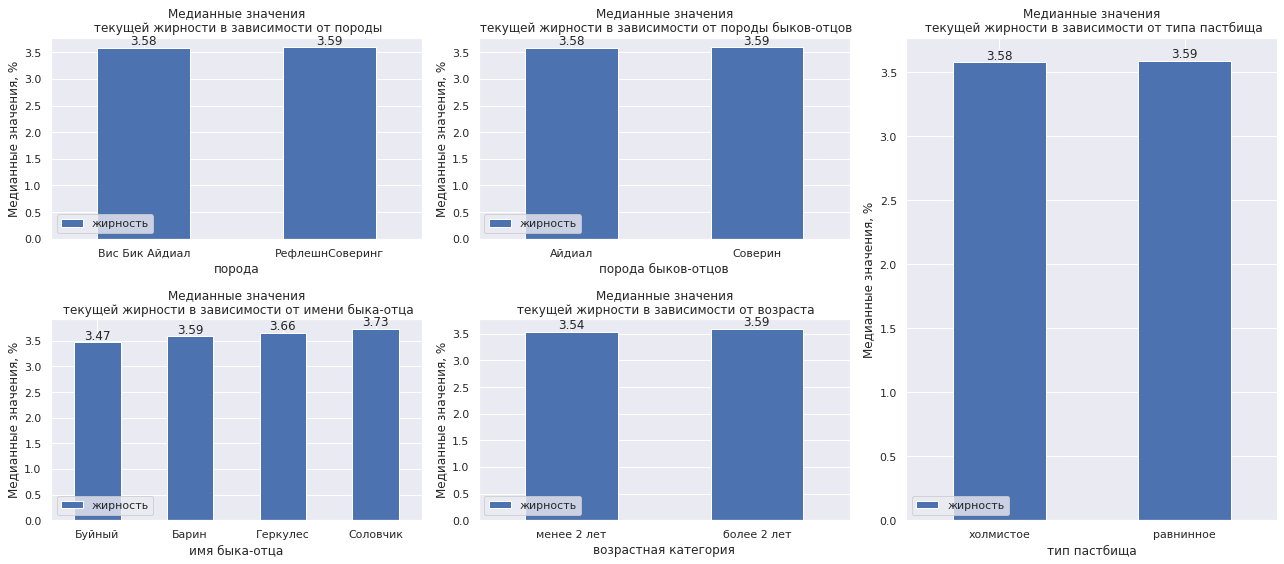

In [558]:
median_estimate(cow_buy, 'current_fat_content', 'текущей жирности', 'жирность', '%', 'cow_buys', tablerepresent=False)

In [559]:
cow_buy.pivot_table(index=['father_breed', 'father_name'], values=['current_fat_content'], aggfunc='median')

current_fat_content
father_breed father_name                     
Айдиал       Буйный                      3.40
             Геркулес                    3.58
Соверин      Барин                       3.59
             Буйный                      3.54
             Геркулес                    3.73
             Соловчик                    3.73

Анализ типичных (в данном случае медианных значений) показывает следующее:
- Типичный уровень жирности молока выше у коров породы `РефлешнСоверин`
- Типичный уровень жирности молока выше у коров, чьи отцы имеют породу `Соверин`
- Типичный уровень жирности молока наибольший у коров, чьих отцов зовут `Соловчик`, наименьший -  у коров, чьих отцов зовут `Буйный`
- У коров постарше молоко в среднем жирнее
- На равнинных пастбищах в среднем коровы дают более жирное молоко
- Более детальный анализ также показал, что максимальная жирность у молока коров, чьи отцы имеют породу `Соверин` и имя `Соловчик`
- Минимальая жирность у молока коров, чьи отцы имеют породу `Айдиал` и имя `Буйный`

#### Работа со столбцом `current_protein_level`

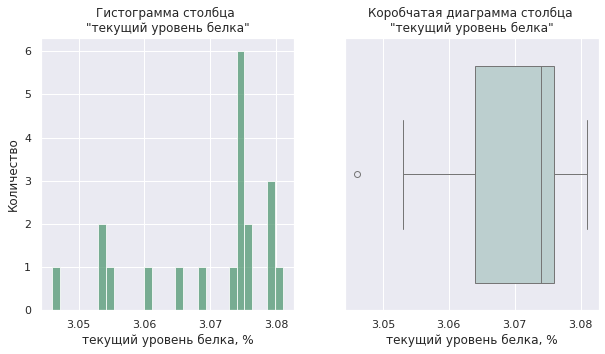

In [560]:
plot_graphics(cow_buy, 'current_protein_level', col_alias='\n"текущий уровень белка"', xlabel='текущий уровень белка, %')

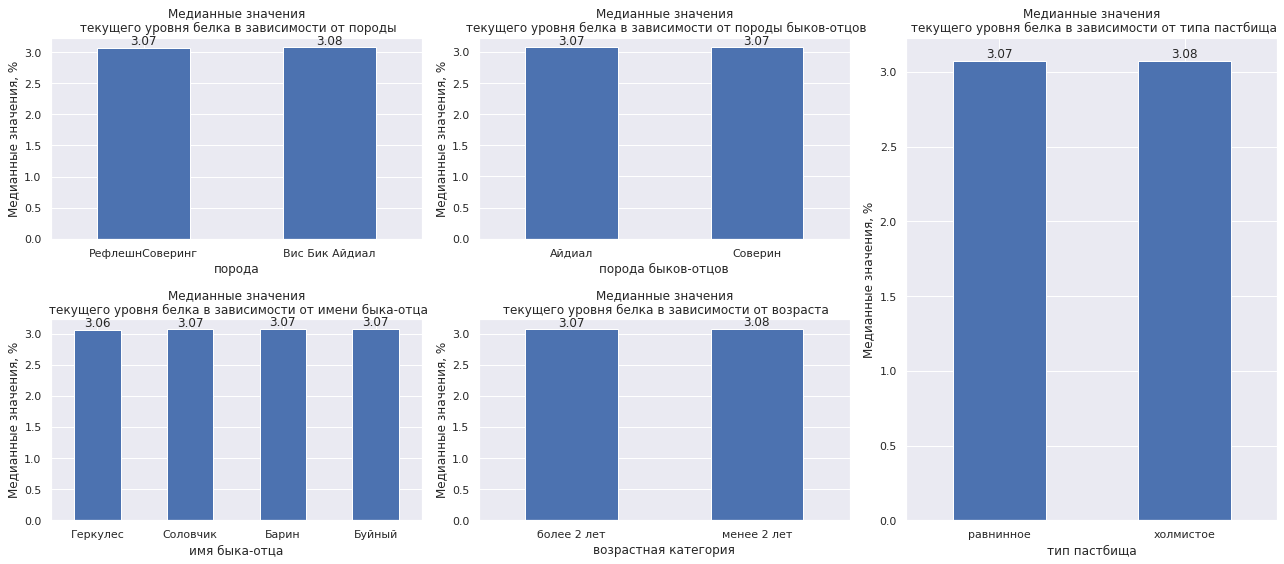

In [561]:
median_estimate(cow_buy, 'current_protein_level', 'текущего уровня белка', 'уровень белка', '%', 'cow_buys', legendbool=False, tablerepresent=False)

In [562]:
cow_buy.pivot_table(index=['father_breed', 'father_name'], values=['current_protein_level'], aggfunc='median')

current_protein_level
father_breed father_name                       
Айдиал       Буйный                       3.074
             Геркулес                     3.076
Соверин      Барин                        3.074
             Буйный                       3.079
             Геркулес                     3.053
             Соловчик                     3.067

Анализ типичных (в данном случае медианных значений) показывает следующее:
- Типичный уровень белка в молока выше у коров породы `Вис Бик Айдиал`
- Типичный уровень белка в молока практически не зависит от породы отца-быка
- Типичный уровень белка в молока наибольший у коров, чьих отцов зовут `Соловчик, Барин, Буйный`, наименьший -  у коров, чьих отцов зовут `Геркулес`
- Типичный уровень белка почти не зависит от возраста
- От типа пастбищ типичное значение уровня белка в молоко не зависит
- Более детальный анализ также показал, что максимальный уровень белка в молоке коров, чьи отцы имеют породу `Соверин` и имя `Буйный`
- Минимальный уровень белка в молока коров, чьи отцы имеют породу `Соверин` и имя `Геркулес`

Портреты коров разной породы

- `Вис Бик Айдиал`
    - Доля породы в данных - `55%`
    - Доля коров этой породы (`Вик Бик Айдиал`) превалирует на холмистых пастбищах (`67%`), однако на равнинных пастбищах их доля составляет только `27%`
    - Доля коров этой породы среди коров, имеющих отца-быка породы `Айдиал` составляет `38%`, среди имеющих отца-быка породы `Соверин` - `50%`
    - Распределение долей пастбищ для коров этой породы несбалансированное (`67%` - `холмистые`, `33%` - `равнинные`)
    - `33%` коров породы `Вис Бик Айдиал` имеют в родителях папу-быка породы `Айдиал`
    - Медианное значение уровня жирности ниже чем у молока коров породы `РефлешнСоверинг`
    - Медианный уровень белка составляет `3.08`
    - Около четверти коров (22%) этой породы молодые (менее 2 лет) 
    - Коровы, чьим отцом является бык с именем `Соловчик` представлены только в породе - `Вис Бик Айдиал`
    

- `РефлешнСоверинг`
    - Доля коров этой породы (`РефлешнСоверинг`) на равнинных пастбищ составляет `73%`, на холмистых - `33%`
    - Доля коров этой породы среди коров, имеющих отца-быка породы `Айдиал` составляет `45%`, среди имеющих отца-быка породы `Соверин` - `55%`
    - Распределение долей пастбищ для коров этой породы несбалансированное (`27%` - `холмистые`, `73%` - `равнинные`)
    - `55%` коров породы `РефлешнСоверинг` имеют в родителях папу-быка породы `Соверин`
    - Медианное значение уровня жирности выше чем у молока коров породы `Вис Бик Айдиал`
    - Медианный уровень белка составляет `3.07`
    - Около `30%` коров этой породы молодые (менее 2 лет)
    - Коровы, чьим отцом является бык с именем `Буйный`, больше представлены в породе - `РефлешнСоверин` (`62%`)
    - Коровы, чьим отцом является бык с именем `Барин`, больше представлены в породе - `РефлешнСоверин` (`75%`)
    - Коровы, чьим отцом является бык породы `Айдиал`, больше представлены в породе - `РефлешнСоверин` (`62%`)


**Комментарий студента:** вывод скорректирован, так как теперь дублирующие строки в датасете cow_buys.csv не удаляются

## Корреляционный анализ

Построим матрицу корреляций $\phi_k$

interval columns not set, guessing: ['milk_yield', 'efu', 'raw_protein', 'spo', 'fat_content', 'protein']


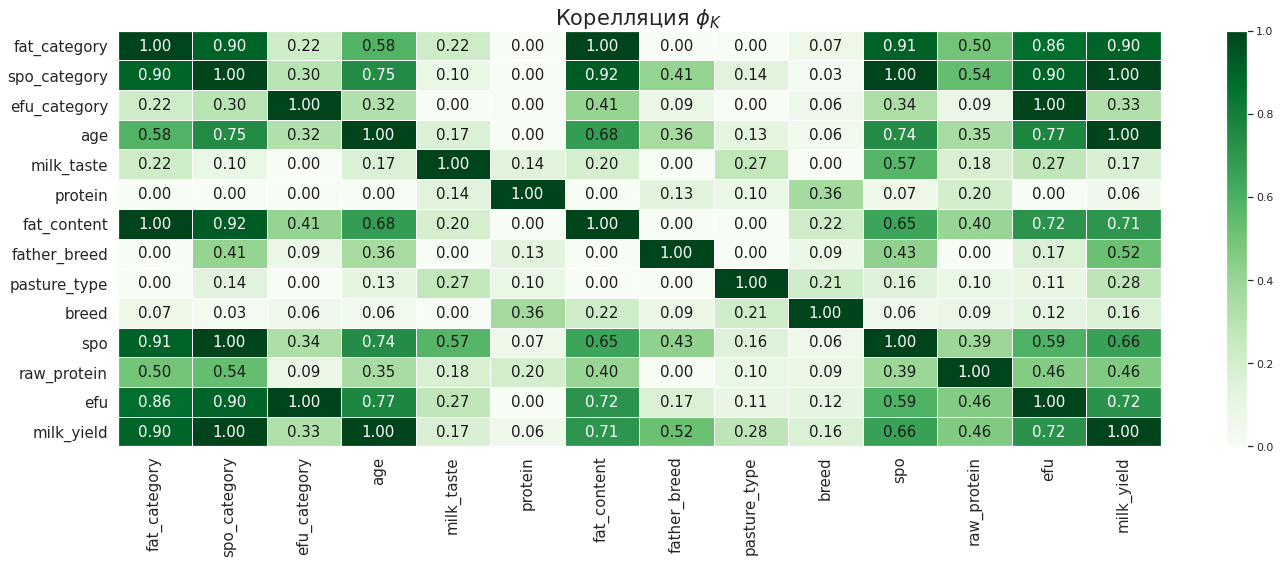

In [564]:
corr = ferma_main.drop('id', axis=1).phik_matrix(njobs=1)
plot_correlation_matrix(corr.values, x_labels=corr.columns, y_labels=corr.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'Корелляция $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,8))

- Между числовыми признаками и их категориальными аналогами есть практически стопроцентная $\phi_k$ корреляция
- Между некоторыми предикторами существует довольно сильная связь

**Комментарий студента:** исправлено, делаю drop столбца `id` при расчете корреляции 

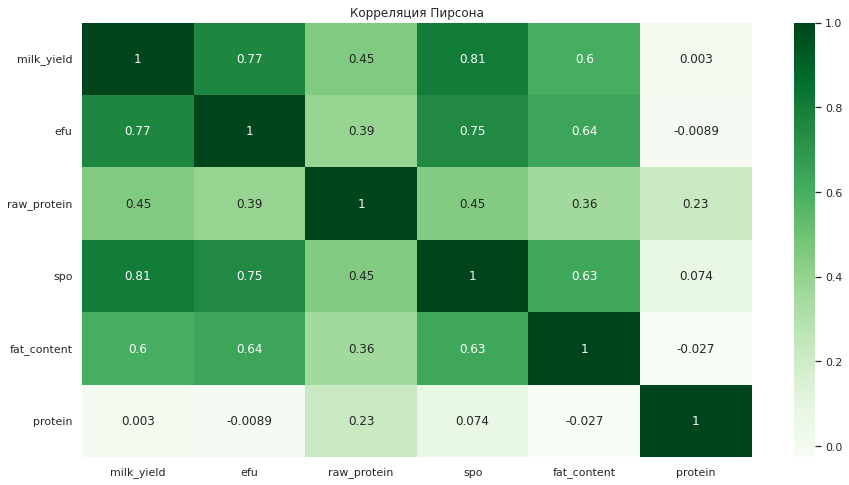

In [565]:
plt.figure(figsize=(15, 8))
corr = ferma_main.drop('id', axis=1).corr(numeric_only=True)
g = sns.heatmap(corr, annot=True, cmap='Greens')
plt.yticks(rotation=0)
plt.title('Корреляция Пирсона')
plt.show()

- Видим довольно высокую связь между `ЭКЕ` и `СПО`

Для целевого признака - `milk_yield` рассмотрим корреляцию $\phi_k$ по всем признакам

interval columns not set, guessing: ['milk_yield', 'efu', 'raw_protein', 'spo', 'fat_content', 'protein']


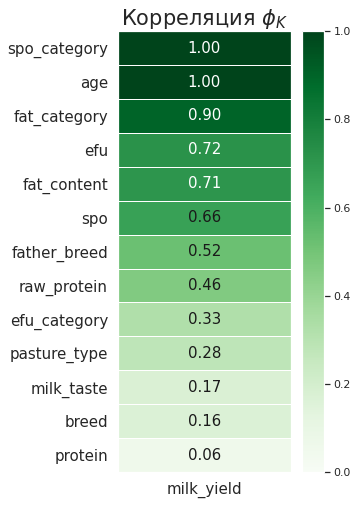

In [567]:
corr = ferma_main.drop('id', axis=1).phik_matrix(njobs=1).loc[:, ['milk_yield']].sort_values('milk_yield')[:-1]
plot_correlation_matrix(corr.values, x_labels=corr.columns, y_labels=corr.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'Корреляция $\phi_K$', fontsize_factor=1.5,
                        figsize=(5,8))
plt.xticks(rotation=0)
plt.show()

- Высокий уровень связи категории СПО, возрастной категории, категории жирности, категории ЭКЕ и таргета
- Интересно, что корреляция $\phi_k$ выявила, что категориальные аналоги влияют на таргет сильнее чем их числовые оригиналы (СПО, ЭКЕ, жирность)

И еще корелляцию Пирсона (для числовых признаков и целевого).

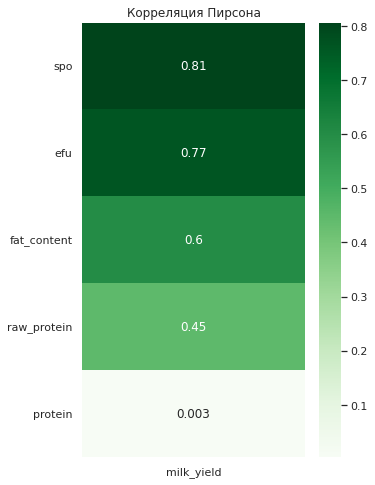

In [568]:
plt.figure(figsize=(5, 8))
corr = ferma_main.drop('id', axis=1).corr(numeric_only=True).loc[:, ["milk_yield"]].sort_values('milk_yield', ascending=False)[1:]
g = sns.heatmap(corr, annot=True, cmap='Greens')
plt.yticks(rotation=0)
plt.title('Корреляция Пирсона')
plt.show()

- Наибольшее линейное влияние на таргет имеют признаки `СПО` и `ЭКЕ`

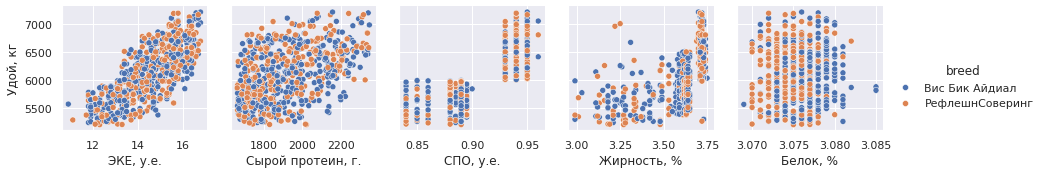

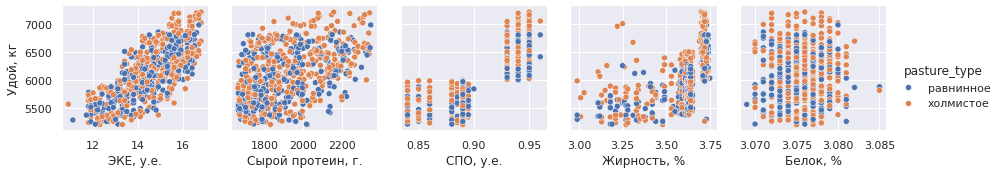

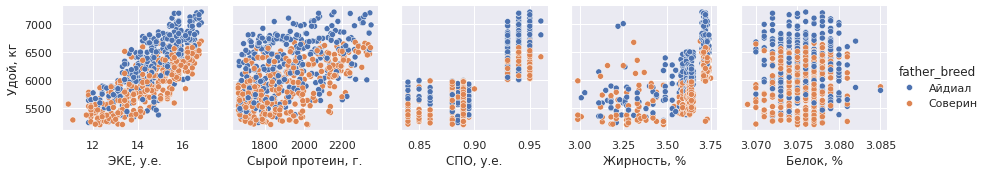

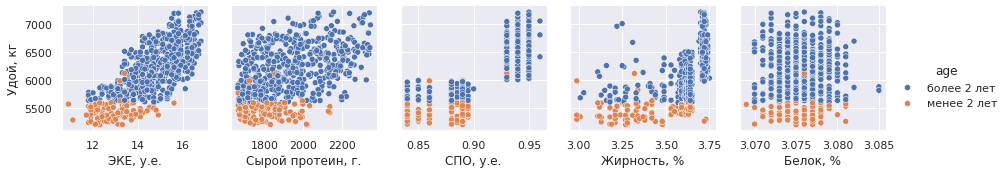

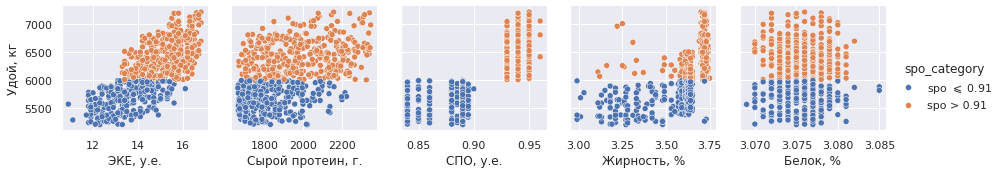

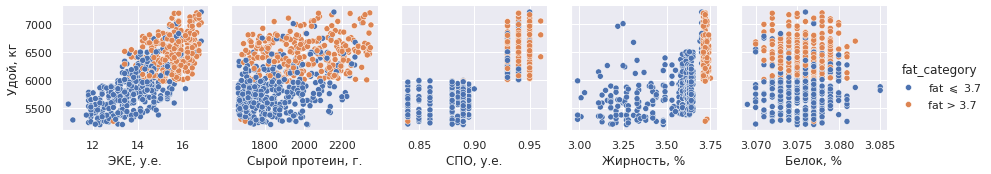

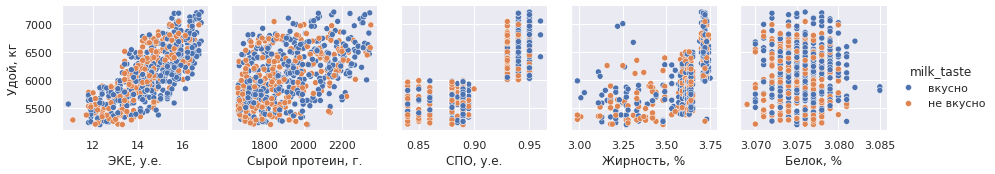

In [569]:
num_cols_labels = ['ЭКЕ, у.е.', 'Сырой протеин, г.', 'СПО, у.е.', 'Жирность, %', 'Белок, %']
num_cols = ['efu', 'raw_protein', 'spo', 'fat_content', 'protein']
categories = ['breed', 'pasture_type', 'father_breed', 'age', 'spo_category', 'fat_category', 'milk_taste']

for cat in categories:
    g = sns.PairGrid(data=ferma_main,
                     hue=cat,
                     x_vars=num_cols,
                     y_vars='milk_yield')
    g.map(sns.scatterplot)
    for idx, ax in enumerate(g.axes.flat):
        ax.set_xlabel(num_cols_labels[idx])
        ax.set_ylabel("Удой, кг")
    g.add_legend()

- Видим идеальное разделение по категории СПО 
- Практически идеальное разделение по возрастной категории 
- Довольно неплохо данные разделяются по категории уровня жирности

In [570]:
with_all = ferma_main[num_cols + ['milk_yield']]
with_all['spo_category'] = with_all['spo'].apply(lambda x: 1 if x > 0.91 else 0)
with_all['efu_category'] = with_all['efu'].apply(lambda x: 1 if x > 14.7 else 0)
with_all['fat_category'] = with_all['fat_content'].apply(lambda x: 1 if x > 3.7 else 0)


without_num = with_all.drop('spo', axis=1)
without_num = without_num.drop('efu', axis=1)
without_num = without_num.drop('fat_content', axis=1)

without_cat = with_all.drop('spo_category', axis=1)
without_cat = without_cat.drop('efu_category', axis=1)
without_cat = without_cat.drop('fat_category', axis=1)


for title, df in [('\n\nСо всеми переменными\n\n', with_all), ('\n\nБез числовых признаков-оригиналов\n\n', without_num), ('\n\nБез категориальных признаков-аналогов\n\n', without_cat)]:

    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X = add_constant(df)

    vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    print(title)
    display(vif)



Со всеми переменными




Variable       VIF
0         const  1.000000
1           efu  5.388225
2   raw_protein  1.384264
3           spo  7.902133
4   fat_content  2.109168
5       protein  1.089476
6    milk_yield  4.228257
7  spo_category  8.512804
8  efu_category  3.469944
9  fat_category  2.731632



Без числовых признаков-оригиналов




Variable       VIF
0         const  1.000000
1   raw_protein  1.359618
2       protein  1.075252
3    milk_yield  3.756643
4  spo_category  3.898506
5  efu_category  1.934213
6  fat_category  2.459737



Без категориальных признаков-аналогов




Variable       VIF
0        const  1.000000
1          efu  2.959531
2  raw_protein  1.374328
3          spo  3.504585
4  fat_content  1.883356
5      protein  1.088308
6   milk_yield  3.556408

- Судя по диаграмме рассения очень полезно будет ввести несколько новых (уже введенных) бинарных признаков-разделителей
- ЭКЕ и годовой удой имеют нелинейную связь. Похожа на квадратичную
- Если оставить все предикторы в данных, то наблюдается мультиколлинеарность
- Если избавиться от одного вида предикторов (кат. аналогов или числовых оригиналов) то мультиколлинеарность исчезает
- Наличие высокой корреляции между предикторами не означает появление мультиколлинеарности (пример: ЭКЕ и СПО имеют высокий коэффициент корреляции Пирсона, однако все VIF меньше 5, поэтому мультиколлинеарность умеренная)

## Регрессия

### Первая модель

Попробуем подобрать признаки для первой модели, опираться будем на корреляцию Пирсона и корреляцию $\phi_k$, а также на причинно следственную связь

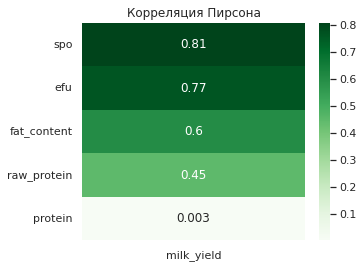

interval columns not set, guessing: ['milk_yield', 'efu', 'raw_protein', 'spo', 'fat_content', 'protein']


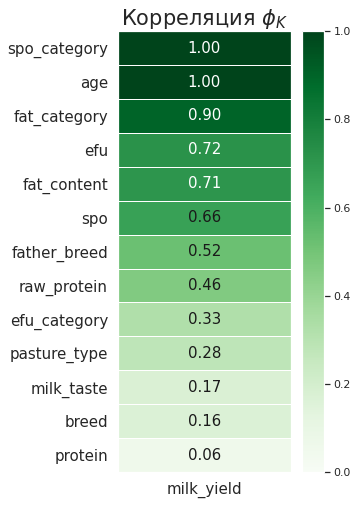

In [571]:
corr_report(ferma_main.drop('id', axis=1))

- По медианным значениям удоя можно заключить, что годовой удой сильно меняется от возрастной категории, породы отца-быка и типа пастбищ
- По итогам корреляционного анализа возьмем признаки СПО, ЭКЕ, сырой протеин

In [572]:
X = ferma_main.drop('milk_yield', axis=1)
y = ferma_main['milk_yield']

model_columns_cat = ['age', 'father_breed', 'pasture_type', 'breed']
model_columns_num = ['spo', 'efu', 'raw_protein']

X_train, X_test, y_train, y_test, e, s = prepare_data(X, y, model_columns_cat, model_columns_num)

model_lr_1  = LinearRegression()
model_lr_1.fit(X_train, y_train)
predictions_1 = model_lr_1.predict(X_test).astype(int)

In [573]:
scores_model_1 = scores_report(predictions_1, y_test, 'test_score_1')
scores_model_1.round(2)

test_score_1
metric              
RMSE          209.39
MSE         43842.70
MAE           164.18
$R^2$           0.78

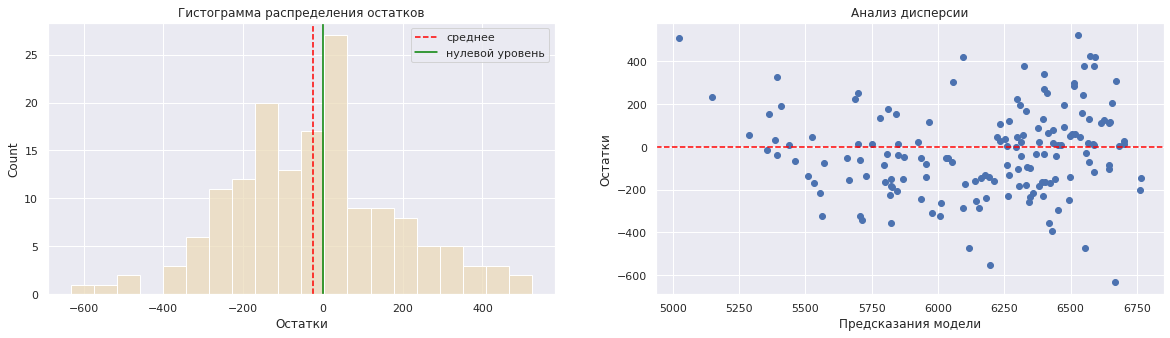

In [574]:
analyze_residuals(y_test - predictions_1, predictions_1)

- Дисперсия остатков неравномерная, особенно это видно в области малых значений годового удоя: модель только занижает предсказания. В области от 6000 до 6250 кг модель преимущественно завышает предсказания
- Распределение остатков же имеет смещение влево: модель в среднем завышает предсказания
- Значение метрик:
    - $RMSE = 209.4$
    - $MAE = 164.2$
    - $R^2 = 0.78$

### Вторая модель

Создаем новый бинарный признак `spo_category`, хотя категориальный его вариант уже существует в данных

In [575]:
ferma_main['spo_category'] = ferma_main['spo'].apply(lambda x: 0 if x <= 0.91 else 1)

Уберем нелинейность зависимости признака ЭКЕ от целевого признака - удой

In [576]:
ferma_main['efu_squared'] = ferma_main['efu'] ** 2

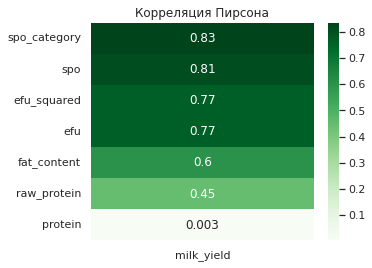

interval columns not set, guessing: ['milk_yield', 'efu', 'raw_protein', 'spo', 'fat_content', 'protein', 'spo_category', 'efu_squared']


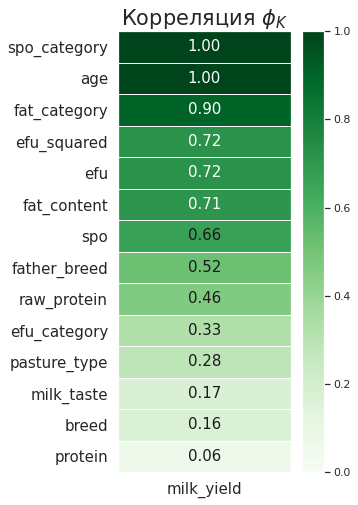

In [577]:
corr_report(ferma_main.drop('id', axis=1))

<Axes: xlabel='efu_squared', ylabel='milk_yield'>

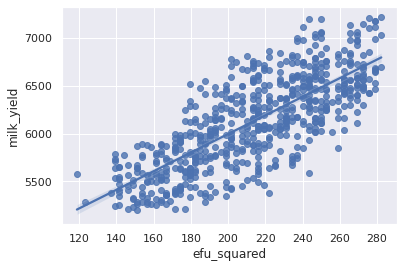

In [578]:
sns.regplot(data=ferma_main, x='efu_squared', y='milk_yield')

In [579]:
X = ferma_main.drop('milk_yield', axis=1)
y = ferma_main['milk_yield']

model_columns_cat = ['age', 'father_breed', 'pasture_type', 'breed', 'spo_category']
model_columns_num = ['efu_squared', 'raw_protein']

X_train, X_test, y_train, y_test, e, s = prepare_data(X, y, model_columns_cat, model_columns_num)

model_lr_2  = LinearRegression()
model_lr_2.fit(X_train, y_train)
predictions_2 = model_lr_2.predict(X_test).astype(int)

In [580]:
scores_model_2 = scores_report(predictions_2, y_test, 'test_score_2')
scores_model_2.round(2)

test_score_2
metric              
RMSE          192.36
MSE         37002.03
MAE           148.96
$R^2$           0.82

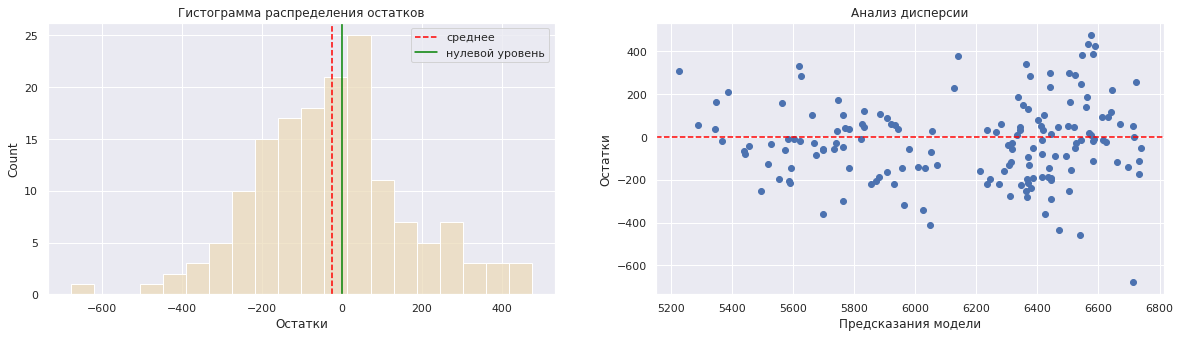

In [581]:
analyze_residuals(y_test - predictions_2, predictions_2)

- Дисперсия остатков все еще неравномерная, особенно это видно в области малых значений годового удоя: модель только занижает предсказания. В области от 6100 до 6200 кг модель только занижает предсказания
- Распределение остатков все еще имеет смещение влево: модель в среднем завышает предсказания
- Значение метрик:
    - $RMSE = 192.4$ (стала ниже)
    - $MAE = 149$ (стала ниже)
    - $R^2 = 0.82$ (стал выше)

### Третья модель

In [582]:
ferma_main_updated = ferma_main.merge(ferma_dad, on='id', how='left')

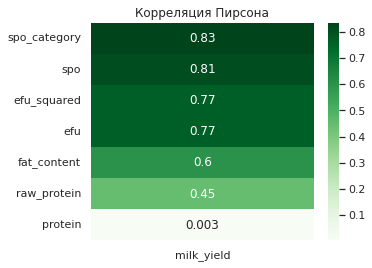

interval columns not set, guessing: ['milk_yield', 'efu', 'raw_protein', 'spo', 'fat_content', 'protein', 'spo_category', 'efu_squared']


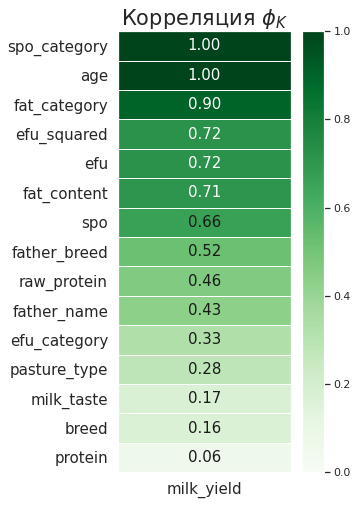

In [583]:
corr_report(ferma_main_updated.drop('id', axis=1))

In [584]:
X = ferma_main_updated.drop('milk_yield', axis=1)
y = ferma_main_updated['milk_yield']

model_columns_cat = ['age', 'pasture_type', 'father_name', 'breed']
model_columns_num = ['efu_squared', 'raw_protein', 'spo_category']

X_train, X_test, y_train, y_test, encoder_3, scaler_3 = prepare_data(X, y, model_columns_cat, model_columns_num)

model_lr_3  = LinearRegression()
model_lr_3.fit(X_train, y_train)
predictions_3 = model_lr_3.predict(X_test).astype(int)

In [585]:
scores_model_3 = scores_report(predictions_3, y_test, 'test_score_3')
scores_model_3.round(2)

test_score_3
metric              
RMSE          187.88
MSE         35300.47
MAE           144.59
$R^2$           0.83

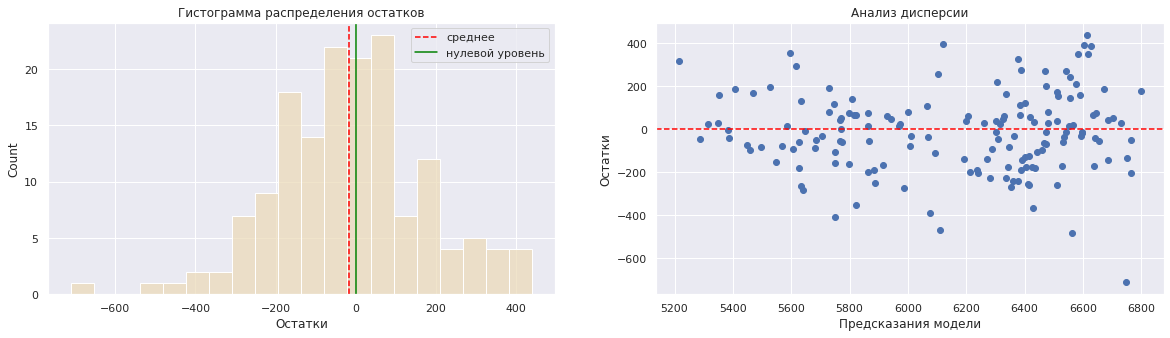

In [586]:
analyze_residuals(y_test - predictions_3, predictions_3)

- Дисперсия остатков все еще неравномерная, однако она стала более повсеместной. В коридоре от 6000 до 6200 модель стала ошибаться в обе стороны.
- Распределение остатков же имеет смещение влево, но среднее стало ближе к нулевому уровню остатков
- Значение метрик:
    - $RMSE = 187.9$ (стала ниже)
    - $MAE = 144.6$ (стала ниже)
    - $R^2 = 0.83$ (стал выше)

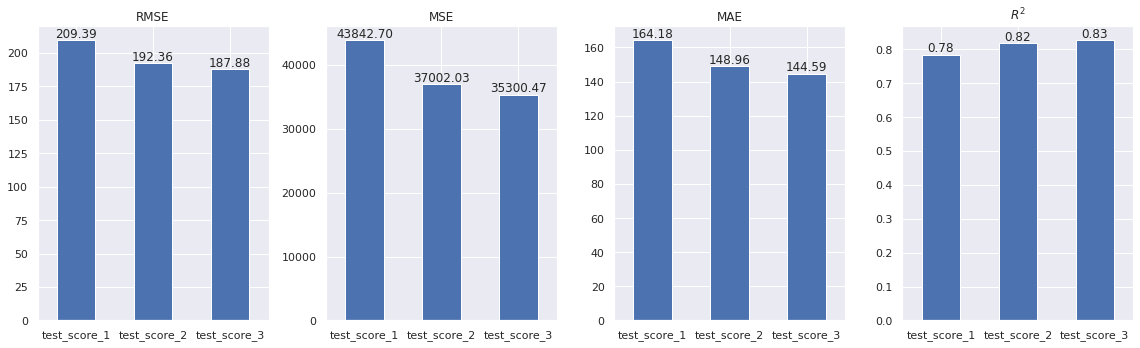

In [588]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
for idx, (title, metric) in enumerate(scores_model_1.join([scores_model_2, scores_model_3]).iterrows()):
    metric.plot(kind='bar', ax=ax[idx], title=title)
    ax[idx].tick_params(rotation=0)
    add_bar_labels(ax[idx])

Третья модель имеет самые высокие показатели, особенно по коэффициенту детерминации. Согласно этой метрике в 83% случаев предсказание третьей модели ближе к истине, чем среднее значение таргета 

### Доверительный интервал для лучшей модели

In [589]:
alpha = .05

In [590]:
confidence_interval = np.quantile(predictions_3, q=[alpha, 1 - alpha]).round(2)
print(f'Доверительный интервал предсказаний модели - [{confidence_interval[0]}, {confidence_interval[1]}]')

Доверительный интервал предсказаний модели - [5441.0, 6687.0]


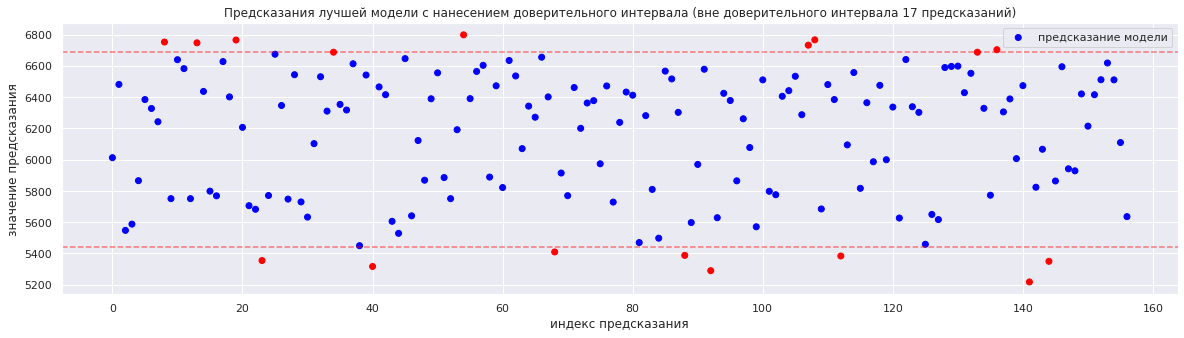

In [591]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
out_of_confidence = (predictions_3 <= confidence_interval[0]) | (predictions_3 >= confidence_interval[1])
ax.scatter(range(len(predictions_3)), predictions_3, marker='o', color=np.where(out_of_confidence,'red','blue'), label='предсказание модели')
ax.axhline(y=confidence_interval[0], color='red', ls='--', alpha=0.5)
ax.axhline(y=confidence_interval[1], color='red', ls='--', alpha=0.5)
ax.set_title(f'Предсказания лучшей модели с нанесением доверительного интервала (вне доверительного интервала {out_of_confidence.sum()} предсказаний)')
ax.set_xlabel('индекс предсказания')
ax.set_ylabel('значение предсказания')
ax.legend()
plt.show()

### Предсказание

#### Подготовка

In [592]:
for col in ['spo', 'efu', 'raw_protein']:
    cow_buy[col] = ferma_main[col].median() * 1.05

In [593]:
cow_buy['spo_category'] = cow_buy['spo'].apply(lambda x: 0 if x <= 0.91 else 1)

In [594]:
cow_buy['efu_squared'] = cow_buy['efu'] ** 2

In [595]:
cow_buy

breed pasture_type father_breed father_name  \
0    Вис Бик Айдиал    холмистое       Айдиал    Геркулес   
1    Вис Бик Айдиал    равнинное      Соверин      Буйный   
2   РефлешнСоверинг    равнинное      Соверин       Барин   
3   РефлешнСоверинг    холмистое       Айдиал      Буйный   
4   РефлешнСоверинг    равнинное       Айдиал      Буйный   
5   РефлешнСоверинг    равнинное      Соверин    Геркулес   
6    Вис Бик Айдиал    холмистое       Айдиал    Геркулес   
7    Вис Бик Айдиал    равнинное      Соверин      Буйный   
8   РефлешнСоверинг    равнинное      Соверин       Барин   
9   РефлешнСоверинг    холмистое       Айдиал      Буйный   
10   Вис Бик Айдиал    холмистое      Соверин    Соловчик   
11  РефлешнСоверинг    равнинное      Соверин    Геркулес   
12   Вис Бик Айдиал    холмистое       Айдиал    Геркулес   
13   Вис Бик Айдиал    холмистое      Соверин       Барин   
14  РефлешнСоверинг    равнинное      Соверин       Барин   
15  РефлешнСоверинг    холмистое       Айдиал      Буйный   
16   Вис Бик Айдиал    холмистое      Соверин    Соловчик   
17  РефлешнСоверинг    равнинное      Соверин    Геркулес   
18   Вис Бик Айдиал    равнинное      Соверин      Буйный   
19  РефлешнСоверинг    равнинное       Айдиал      Буйный   

    current_fat_content  current_protein_level          age     spo     efu  \
0                  3.58                  3.076  более 2 лет  0.9765  15.435   
1                  3.54                  3.081  менее 2 лет  0.9765  15.435   
2                  3.59                  3.074  более 2 лет  0.9765  15.435   
3                  3.40                  3.061  более 2 лет  0.9765  15.435   
4                  3.64                  3.074  более 2 лет  0.9765  15.435   
5                  3.63                  3.053  менее 2 лет  0.9765  15.435   
6                  3.58                  3.076  более 2 лет  0.9765  15.435   
7                  3.57                  3.079  более 2 лет  0.9765  15.435   
8                  3.59                  3.074  более 2 лет  0.9765  15.435   
9                  3.40                  3.079  менее 2 лет  0.9765  15.435   
10                 3.73                  3.055  более 2 лет  0.9765  15.435   
11                 3.73                  3.073  более 2 лет  0.9765  15.435   
12                 3.68                  3.046  более 2 лет  0.9765  15.435   
13                 3.42                  3.075  менее 2 лет  0.9765  15.435   
14                 3.59                  3.074  более 2 лет  0.9765  15.435   
15                 3.40                  3.065  более 2 лет  0.9765  15.435   
16                 3.73                  3.079  более 2 лет  0.9765  15.435   
17                 3.77                  3.053  менее 2 лет  0.9765  15.435   
18                 3.34                  3.069  более 2 лет  0.9765  15.435   
19                 3.64                  3.074  более 2 лет  0.9765  15.435   

    raw_protein  spo_category  efu_squared  
0        1982.4             1   238.239225  
1        1982.4             1   238.239225  
2        1982.4             1   238.239225  
3        1982.4             1   238.239225  
4        1982.4             1   238.239225  
5        1982.4             1   238.239225  
6        1982.4             1   238.239225  
7        1982.4             1   238.239225  
8        1982.4             1   238.239225  
9        1982.4             1   238.239225  
10       1982.4             1   238.239225  
11       1982.4             1   238.239225  
12       1982.4             1   238.239225  
13       1982.4             1   238.239225  
14       1982.4             1   238.239225  
15       1982.4             1   238.239225  
16       1982.4             1   238.239225  
17       1982.4             1   238.239225  
18       1982.4             1   238.239225  
19       1982.4             1   238.239225

#### Предсказание удоя коров из `ЭкоФерма` 

In [596]:
X = cow_buy.copy()

encoded = pd.DataFrame(encoder_3.transform(X[model_columns_cat]), columns=encoder.get_feature_names_out())
scaled = pd.DataFrame(scaler_3.transform(X[model_columns_num]), columns=model_columns_num)

X = pd.concat([scaled, encoded], axis=1)
X = X.sort_index(axis=1)

predictions = model_lr_3.predict(X)

<div class="alert alert-warning">
<b>🤔 Рекомендация:</b> В этом проекте нам "повезло" и лучшей моделью оказалась последняя обученная, и последние обученные кодировщик и скайлер. Но так может быть не всегда, поэтому для каждой модели нужно сохранять и саму обученную модель и кодировщик со скайлером, использую названия привязанные к номеру модели
</div>

In [597]:
cow_buy['milk_yield'] = predictions

In [598]:
predictions

array([6618.85512036, 6344.68656976, 6291.55169993, 6602.43937961,
       6553.44028076, 6390.57887518, 6618.85512036, 6538.70199843,
       6291.55169993, 6408.42395094, 6349.25565667, 6584.59430385,
       6618.85512036, 6131.79708778, 6291.55169993, 6602.43937961,
       6349.25565667, 6390.57887518, 6538.70199843, 6553.44028076])

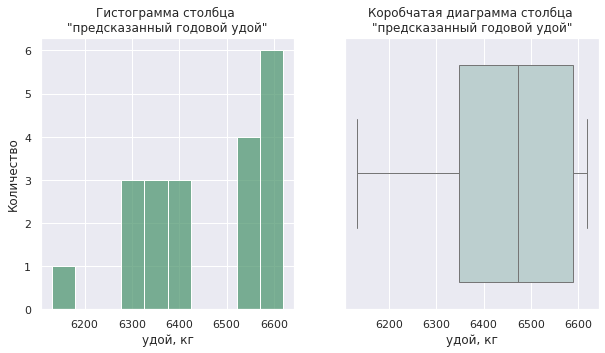

In [599]:
plot_graphics(cow_buy, 'milk_yield', col_alias='\n"предсказанный годовой удой"', xlabel='удой, кг', bins=10)

По предсказаниям видим, что одному из требований заказчика (годовой удой выше 6000 кг) все коровы ЭкоФермы удовлетворяют

## Классификация

In [600]:
ferma_main_with_bin_taste = ferma_main_updated.copy()
ferma_main_with_bin_taste['milk_taste'] = ferma_main_with_bin_taste['milk_taste'].apply(lambda x: 1 if x == 'вкусно' else 0)

In [601]:
X = ferma_main_with_bin_taste.drop('milk_taste', axis=1)
y = ferma_main_with_bin_taste['milk_taste']

model_columns_cat = ['age', 'pasture_type', 'father_name', 'breed', 'father_breed', 'spo_category']
model_columns_num = ['efu_squared', 'raw_protein', 'fat_content', 'protein']

X_train, X_test, y_train, y_test, encoder_clf, scaler_clf = prepare_data(X, 
                                                y, 
                                                model_columns_cat, 
                                                model_columns_num, 
                                                stratify=y)

model_clf  = LogisticRegression()
model_clf.fit(X_train, y_train)
predictions = model_clf.predict(X_test)
predictions_proba = model_clf.predict_proba(X_test)[:, 1]

In [602]:
X_train.head()

age_менее 2 лет  breed_РефлешнСоверинг  efu_squared  fat_content  \
0              1.0                    1.0    -1.259928     0.188714   
1              0.0                    1.0     0.148488     0.684928   
2              1.0                    1.0    -1.328703    -0.803713   
3              0.0                    1.0    -0.542741     0.064661   
4              0.0                    0.0     0.148488     0.684928   

   father_breed_Соверин  father_name_Буйный  father_name_Геркулес  \
0                   1.0                 0.0                   0.0   
1                   1.0                 0.0                   0.0   
2                   0.0                 0.0                   0.0   
3                   1.0                 0.0                   0.0   
4                   1.0                 0.0                   0.0   

   father_name_Соловчик  pasture_type_холмистое   protein  raw_protein  \
0                   0.0                     0.0 -0.993359    -1.222334   
1                   0.0                     1.0  0.156204    -0.947910   
2                   0.0                     1.0 -1.376546    -0.843629   
3                   0.0                     0.0  0.156204     0.391278   
4                   0.0                     1.0  0.156204     1.192596   

   spo_category_1  
0             0.0  
1             1.0  
2             0.0  
3             0.0  
4             1.0

Посмотрим на отношение шансов

In [603]:
for feature_number, feature_name in enumerate(X_train.columns):
    exp_weight = math.exp(model_clf.coef_[0, feature_number])
    print(f"{feature_name:<25}: {exp_weight:+.6f}")

age_менее 2 лет          : +0.799768
breed_РефлешнСоверинг    : +0.920407
efu_squared              : +2.078630
fat_content              : +0.935185
father_breed_Соверин     : +0.966940
father_name_Буйный       : +0.987459
father_name_Геркулес     : +0.600156
father_name_Соловчик     : +0.544845
pasture_type_холмистое   : +1.860137
protein                  : +1.234205
raw_protein              : +1.299840
spo_category_1           : +0.440095


In [604]:
clf_scores = pd.DataFrame([
    {
        'threshold': 0.5,
        'Accuracy' : accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions),
        'Recall'   : recall_score(y_test, predictions),
        'F1-score' : f1_score(y_test, predictions),
        
    }
], columns=['threshold','Accuracy', 'Precision', 'Recall', 'F1-score'])
clf_scores.round(2)

threshold  Accuracy  Precision  Recall  F1-score
0        0.5      0.59       0.63    0.73      0.67

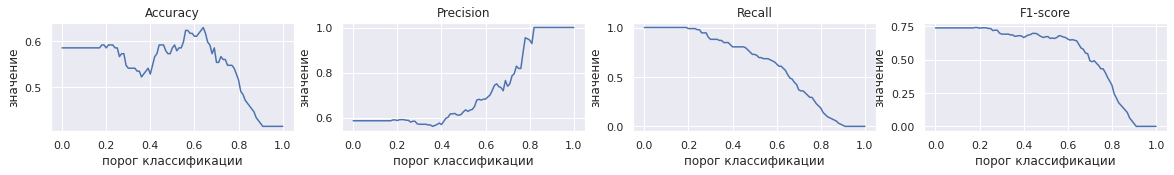

In [605]:
columns = ['threshold','Accuracy', 'Precision', 'Recall', 'F1-score']
clf_scores = pd.DataFrame(
    [
    {
        'threshold': threshold.round(2),
        'Accuracy' : accuracy_score(y_test, predictions_proba >= threshold),
        'Precision': precision_score(y_test, predictions_proba >= threshold, zero_division=1),
        'Recall'   : recall_score(y_test, predictions_proba >= threshold, zero_division=1),
        'F1-score' : f1_score(y_test, predictions_proba >= threshold, zero_division=1),
        
    } for threshold in np.arange(0, 1.01, .01)
], columns=columns
)

fig, ax = plt.subplots(1,4, figsize=(20,2))
axes = ax.flatten()

for idx, ax in enumerate(axes):
    ax.plot(clf_scores.threshold, clf_scores[columns[idx+1]])
    ax.set_title(columns[idx+1])
    ax.set_xlabel('порог классификации')
    ax.set_ylabel('значение')
    
    

Так как заказчику важно не ошибиться - не купить корову, чей удой невкусный. То есть необходимо минимизировать ошибку первого рода (ложноположительный результат). Для этого будем максимизировать метрику precision:
$$ precision = \frac{TP}{TP+FP}. $$ Будем минимизировать количество FP результатов

In [606]:
threshold_optim = clf_scores.loc[clf_scores.Precision.argmax(), 'threshold']
threshold_optim

0.82

При дефолтном пороге 0.5

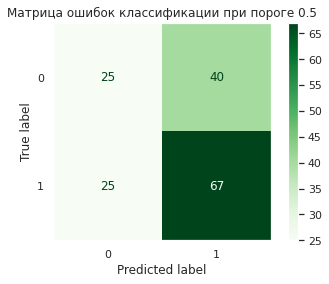

In [607]:
_d = ConfusionMatrixDisplay.from_predictions(y_test, predictions_proba >= .5, cmap='Greens');
_d.figure_.axes[0].set_title(f'Матрица ошибок классификации при пороге 0.5')
_d.figure_.axes[0].grid(False)

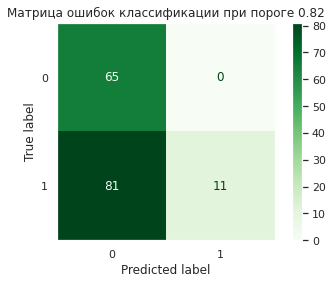

In [608]:
_d = ConfusionMatrixDisplay.from_predictions(y_test, predictions_proba >= threshold_optim, cmap='Greens');
_d.figure_.axes[0].set_title(f'Матрица ошибок классификации при пороге {threshold_optim}')
_d.figure_.axes[0].grid(False)

Видим, что количество FP сократилось до нуля. При таком пороге заказчик точно не купит плохую корову

In [609]:
X = cow_buy.copy()

X = X.rename(columns={
    'current_fat_content': 'fat_content',
    'current_protein_level': 'protein'
})

encoded = pd.DataFrame(encoder.transform(X[model_columns_cat]), columns=encoder.get_feature_names_out())
scaled = pd.DataFrame(scaler.transform(X[model_columns_num]), columns=model_columns_num)

X = pd.concat([scaled, encoded], axis=1)
X = X.sort_index(axis=1)

predictions = model_clf.predict(X)
predictions_proba = model_clf.predict_proba(X)[:,1]

In [610]:
predicted_milk_taste = (predictions_proba >= threshold_optim).astype(int)

In [611]:
cow_buy['predicted_milk_taste'] = predicted_milk_taste
cow_buy['predicted_milk_taste_prob'] = predictions_proba

In [612]:
cow_buy.query('milk_yield > 6000')

breed pasture_type father_breed father_name  \
0    Вис Бик Айдиал    холмистое       Айдиал    Геркулес   
1    Вис Бик Айдиал    равнинное      Соверин      Буйный   
2   РефлешнСоверинг    равнинное      Соверин       Барин   
3   РефлешнСоверинг    холмистое       Айдиал      Буйный   
4   РефлешнСоверинг    равнинное       Айдиал      Буйный   
5   РефлешнСоверинг    равнинное      Соверин    Геркулес   
6    Вис Бик Айдиал    холмистое       Айдиал    Геркулес   
7    Вис Бик Айдиал    равнинное      Соверин      Буйный   
8   РефлешнСоверинг    равнинное      Соверин       Барин   
9   РефлешнСоверинг    холмистое       Айдиал      Буйный   
10   Вис Бик Айдиал    холмистое      Соверин    Соловчик   
11  РефлешнСоверинг    равнинное      Соверин    Геркулес   
12   Вис Бик Айдиал    холмистое       Айдиал    Геркулес   
13   Вис Бик Айдиал    холмистое      Соверин       Барин   
14  РефлешнСоверинг    равнинное      Соверин       Барин   
15  РефлешнСоверинг    холмистое       Айдиал      Буйный   
16   Вис Бик Айдиал    холмистое      Соверин    Соловчик   
17  РефлешнСоверинг    равнинное      Соверин    Геркулес   
18   Вис Бик Айдиал    равнинное      Соверин      Буйный   
19  РефлешнСоверинг    равнинное       Айдиал      Буйный   

    current_fat_content  current_protein_level          age     spo     efu  \
0                  3.58                  3.076  более 2 лет  0.9765  15.435   
1                  3.54                  3.081  менее 2 лет  0.9765  15.435   
2                  3.59                  3.074  более 2 лет  0.9765  15.435   
3                  3.40                  3.061  более 2 лет  0.9765  15.435   
4                  3.64                  3.074  более 2 лет  0.9765  15.435   
5                  3.63                  3.053  менее 2 лет  0.9765  15.435   
6                  3.58                  3.076  более 2 лет  0.9765  15.435   
7                  3.57                  3.079  более 2 лет  0.9765  15.435   
8                  3.59                  3.074  более 2 лет  0.9765  15.435   
9                  3.40                  3.079  менее 2 лет  0.9765  15.435   
10                 3.73                  3.055  более 2 лет  0.9765  15.435   
11                 3.73                  3.073  более 2 лет  0.9765  15.435   
12                 3.68                  3.046  более 2 лет  0.9765  15.435   
13                 3.42                  3.075  менее 2 лет  0.9765  15.435   
14                 3.59                  3.074  более 2 лет  0.9765  15.435   
15                 3.40                  3.065  более 2 лет  0.9765  15.435   
16                 3.73                  3.079  более 2 лет  0.9765  15.435   
17                 3.77                  3.053  менее 2 лет  0.9765  15.435   
18                 3.34                  3.069  более 2 лет  0.9765  15.435   
19                 3.64                  3.074  более 2 лет  0.9765  15.435   

    raw_protein  spo_category  efu_squared   milk_yield  predicted_milk_taste  \
0        1982.4             1   238.239225  6618.855120                     0   
1        1982.4             1   238.239225  6344.686570                     0   
2        1982.4             1   238.239225  6291.551700                     0   
3        1982.4             1   238.239225  6602.439380                     0   
4        1982.4             1   238.239225  6553.440281                     0   
5        1982.4             1   238.239225  6390.578875                     0   
6        1982.4             1   238.239225  6618.855120                     0   
7        1982.4             1   238.239225  6538.701998                     0   
8        1982.4             1   238.239225  6291.551700                     0   
9        1982.4             1   238.239225  6408.423951                     0   
10       1982.4             1   238.239225  6349.255657                     0   
11       1982.4             1   238.239225  6584.594304                     0   
12       1982.4    

In [613]:
cow_buy.query('predicted_milk_taste_prob > @threshold_optim and milk_yield > 6000')

Empty DataFrame
Columns: [breed, pasture_type, father_breed, father_name, current_fat_content, current_protein_level, age, spo, efu, raw_protein, spo_category, efu_squared, milk_yield, predicted_milk_taste, predicted_milk_taste_prob]
Index: []

В результате видим, что все коровы не подходят под требования. Причем вся проблема кроется в высоком пороге классификации. Порог, рассчитанный на обучающей выборке не подходит под выборку из ЭкоФермы. Попробуем отсортировать данные по вероятности, рассчитанной бинарным классификатором и выберем 5 наиболее перспективных коров

In [614]:
cow_buy.sort_values('predicted_milk_taste_prob', ascending=False).head(5)

breed pasture_type father_breed father_name  \
9   РефлешнСоверинг    холмистое       Айдиал      Буйный   
13   Вис Бик Айдиал    холмистое      Соверин       Барин   
7    Вис Бик Айдиал    равнинное      Соверин      Буйный   
16   Вис Бик Айдиал    холмистое      Соверин    Соловчик   
1    Вис Бик Айдиал    равнинное      Соверин      Буйный   

    current_fat_content  current_protein_level          age     spo     efu  \
9                  3.40                  3.079  менее 2 лет  0.9765  15.435   
13                 3.42                  3.075  менее 2 лет  0.9765  15.435   
7                  3.57                  3.079  более 2 лет  0.9765  15.435   
16                 3.73                  3.079  более 2 лет  0.9765  15.435   
1                  3.54                  3.081  менее 2 лет  0.9765  15.435   

    raw_protein  spo_category  efu_squared   milk_yield  predicted_milk_taste  \
9        1982.4             1   238.239225  6408.423951                     0   
13       1982.4             1   238.239225  6131.797088                     0   
7        1982.4             1   238.239225  6538.701998                     0   
16       1982.4             1   238.239225  6349.255657                     0   
1        1982.4             1   238.239225  6344.686570                     0   

    predicted_milk_taste_prob  
9                    0.770804  
13                   0.719898  
7                    0.688754  
16                   0.680010  
1                    0.678002

Коровы выше определены нашим классификатором как наиболее надежные в плане вкуса молока. Если после получения отчета заказчик все же захочет заключить договор с ЭкоФермой, то ему следует обратить внимание именно на этих коров

## Итоговый вывод

В ходе базового изучения датасетов были проведены следующие работы

- Были изменены названия столбцов на английские аналоги
- Были исследованы заданные датасеты
- Пропусков в данных не обнаружено

По предобработке были совершены следующие шаги

- Выявили полные дубликаты, а затем удалили их
- Изменили типы данных для столбцов, которые предполагались в ТЗ как числовые. Проблема крылась в использовании запятой как разделителя целой и дробных частей
- Убрали нижнее подчеркивание из столбца с возрастной категорией
- Выявили невяные дубликаты в данных по пастбищам и породе. Привели к нужным категориям. Скорее всего это была опечатка

Далее был проведен детальный исследовательский анализ, по результатам которых были составлены характерные портреты коров заказчика и коров, которые он хочет купить

Коровы заказчика:

- `Вис Бик Айдиал`
    - Доля породы в данных - `60%`
    - Медианный удой - `6112.5 кг`
    - В категории низких значений ЭКЕ при распределении по породам доля коров этой породы составляет около `80%`
    - Медианные значения сырого протеина удоя молока коров этой породы несколько ниже чем у `РефлешнСоверинг` (`1885 г`)
    - Доля коров этой породы (`Вик Бик Айдиал`) превалирует на всех типах пастбищ (особенно на равнинных пастбищах, более чем в два раза)
    - В разрезе вкуса молока 60% коров этой породы имеют невкусное молоко и также  60%  коров этой породы имеет вкусное молоко
    - Интересно, что порода папы-быка `Соверин` превалирует также и для коров породы `Вис Бик Айдиал`, а также среди потомков быков породы `Айдиал` большинство коров имеют породу `Вис Бик Айдиал`
    - СПО молока коров этой породы составляе `0.93`
    - Однако распределение долей пастбищ для коров этой породы сбалансированно (50/50)
    - `53%` коров породы `Вис Бик Айдиал` имеют в родителях папу-быка породы `Айдиал`
    - Медианное значение уровня жирности ниже чем у молока коров породы `РефлешнСоверинг`
    - Медианный уровень белка составляет `3.076`
    - Около `20%` коров этой породы молодые (менее 2 лет)


- `РефлешнСоверинг`
    - Медианный удой - `6178.5 кг`
    - В категории низких значений ЭКЕ при распределении по породам доля коров этой породы составляет около `20%`
    - Медианные значения сырого протеина удоя молока коров этой породы несколько ниже чем у `РефлешнСоверинг` (`1889.5 г`)
    - Доля коров этой породы (`РефлешнСоверинг`) на равнинных пастбищ составляет `33%`, на холмистых - `47%`
    - В разрезе вкуса молока 40% коров этой породы имеют невкусное молоко и также `40%`  коров этой породы имеет вкусное молоко
    - Доля коров этой породы среди коров, имеющих отца-быка породы `Айдиал` составляет `37%`, среди имеющих отца-быка породы `Соверин` - `44%`
    - СПО молока коров этой породы составляе `0.93`
    - Распределение долей пастбищ для коров этой породы несбалансированное (`64%` - `холмистые`, `36%` - `равнинные`)
    - `54%` коров породы `РефлешнСоверинг` имеют в родителях папу-быка породы `Соверин`
    - Медианное значение уровня жирности выше чем у молока коров породы `Вис Бик Айдиал`
    - Медианный уровень белка составляет `3.075`
    - Около `15%` коров этой породы молодые (менее 2 лет)
    
    
Коровы ЭкоФермы:

- `Вис Бик Айдиал`
    - Доля породы в данных - `55%`
    - Доля коров этой породы (`Вик Бик Айдиал`) превалирует на холмистых пастбищах (`67%`), однако на равнинных пастбищах их доля составляет только `27%`
    - Доля коров этой породы среди коров, имеющих отца-быка породы `Айдиал` составляет `38%`, среди имеющих отца-быка породы `Соверин` - `50%`
    - Распределение долей пастбищ для коров этой породы несбалансированное (`67%` - `холмистые`, `33%` - `равнинные`)
    - `33%` коров породы `Вис Бик Айдиал` имеют в родителях папу-быка породы `Айдиал`
    - Медианное значение уровня жирности ниже чем у молока коров породы `РефлешнСоверинг`
    - Медианный уровень белка составляет `3.08`
    - Около четверти коров (22%) этой породы молодые (менее 2 лет) 
    - Коровы, чьим отцом является бык с именем `Соловчик` представлены только в породе - `Вис Бик Айдиал`
    

- `РефлешнСоверинг`
    - Доля коров этой породы (`РефлешнСоверинг`) на равнинных пастбищ составляет `73%`, на холмистых - `33%`
    - Доля коров этой породы среди коров, имеющих отца-быка породы `Айдиал` составляет `45%`, среди имеющих отца-быка породы `Соверин` - `55%`
    - Распределение долей пастбищ для коров этой породы несбалансированное (`27%` - `холмистые`, `73%` - `равнинные`)
    - `55%` коров породы `РефлешнСоверинг` имеют в родителях папу-быка породы `Соверин`
    - Медианное значение уровня жирности выше чем у молока коров породы `Вис Бик Айдиал`
    - Медианный уровень белка составляет `3.07`
    - Около `30%` коров этой породы молодые (менее 2 лет)
    - Коровы, чьим отцом является бык с именем `Буйный`, больше представлены в породе - `РефлешнСоверин` (`62%`)
    - Коровы, чьим отцом является бык с именем `Барин`, больше представлены в породе - `РефлешнСоверин` (`75%`)
    - Коровы, чьим отцом является бык породы `Айдиал`, больше представлены в породе - `РефлешнСоверин` (`62%`)


Затем был проведен корреляционный анализ:

- По диаграмме рассения выявили, что полезно было рассмотреть преобразование некоторых признаков для уточнения типа связи
- ЭКЕ и годовой удой имеют нелинейную связь. Похожа на квадратичную
- Если оставить все предикторы в данных (в том числе и введенные в ходе EDA категориальные), то наблюдается мультиколлинеарность
- Если избавиться от одного вида предикторов (кат. аналогов или числовых оригиналов) то мультиколлинеарность исчезает
- Наличие высокой корреляции между предикторами не означает появление мультиколлинеарности (пример: ЭКЕ и СПО имеют высокий коэффициент корреляции Пирсона, однако все VIF меньше 5, поэтому мультиколлинеарность умеренная)

По регрессии была избрана третья модель, которая после проведенного feature engineering показала самые высокие значния метрик качества

- Дисперсия остатков все еще неравномерная, однако она стала более повсеместной. В коридоре от 6000 до 6200 модель стала ошибаться в обе стороны.
- Распределение остатков же имеет смещение влево, но среднее стало ближе к нулевому уровню остатков
- Значение метрик:
    - $RMSE = 187.9$ (стала ниже)
    - $MAE = 144.6$ (стала ниже)
    - $R^2 = 0.83$ (стал выше)

Получили доверительный интервал предсказаний: [5441.0, 6687.0]. А затем спрогнозировали удой для коров ЭкоФермы

По классификации в качестве основной метрики качества была избрана метрика precision, так как именно она минимизирует ложноположительные результаты, что является ключевым требованием заказчика

К сожалению, спрогнозированный порог в 0.82 не смог явно найти тех коров, чей удой с точки зрения идеального значения precision имеет категорию `вкусно`. Однако по первому требования - удой больше 6000 кг - все коровы этой фермы подходят. Если после получения отчета заказчик все же захочет заключить договор с ЭкоФермой, то ему следует обратить внимание именно на коров с наиболее высокими значениями спрогнозированной вероятности класса `вкусно`

